In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geoopt
import math

import os
from tqdm.auto import tqdm
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable

from core.active.floating_region import FloatingRegionScore

/home/lfranco/miniconda3/envs/openmmlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def extract_color(c):
    cityspallete = {
            0 :  [128, 64,  128],
            1 :  [244, 35,  232],
            2 :  [70,  70,  70],
            3 :  [102, 102, 156],
            4 :  [190, 153, 153],
            5 :  [153, 153, 153],
            6 :  [250, 170, 30],
            7 :  [220, 220, 0],
            8 :  [107, 142, 35],
            9 :  [152, 251, 152],
            10 : [0,   130, 180],
            11 : [220, 20,  60],
            12 : [255, 0,   0],
            13 : [0,   0,   142],
            14 : [0,   0,   70],
            15 : [0,   60,  100],
            16 : [0,   80,  100],
            17 : [0,   0,   230],
            18 : [119, 11,  32],
            255: [255,   255,   255]}
    return [color/255 for color in cityspallete[c]]

def extract_classname(c):
        trainid2name = {
            0: "road",
            1: "sidewalk",
            2: "building",
            3: "wall",
            4: "fence",
            5: "pole",
            6: "light",
            7: "sign",
            8: "vegetation",
            9: "terrain",
            10: "sky",
            11: "person",
            12: "rider",
            13: "car",
            14: "truck",
            15: "bus",
            16: "train",
            17: "motocycle",
            18: "bicycle",
            255: "unknown",
        }
        return trainid2name[c]

def get_color_pallete(npimg):
    out_img = Image.fromarray(npimg.astype('uint8')).convert('P')
    cityspallete = [
        128, 64, 128,
        244, 35, 232,
        70, 70, 70,
        102, 102, 156,
        190, 153, 153,
        153, 153, 153,
        250, 170, 30,
        220, 220, 0,
        107, 142, 35,
        152, 251, 152,
        0, 130, 180,
        220, 20, 60,
        255, 0, 0,
        0, 0, 142,
        0, 0, 70,
        0, 60, 100,
        0, 80, 100,
        0, 0, 230,
        119, 11, 32,
    ]
    out_img.putpalette(cityspallete)
    return out_img
    
    
def extract_legend(frequent=None):
    most_frequent_class = [0, 1, 2, 8, 10, 13]

    if frequent == 'most':
        patchList = [mpatches.Patch(color=extract_color(k), label=extract_classname(k)) for k in most_frequent_class]
    elif frequent == 'less':
        patchList = [mpatches.Patch(color=extract_color(k), label=extract_classname(k)) for k in range(19) if k not in most_frequent_class]
    else:
        patchList = [mpatches.Patch(color=extract_color(k), label=extract_classname(k)) for k in range(19)]
        
    return patchList

# Draw Geodesics

In [ ]:
checkpoint = torch.load('results/source_free/dlv3_hyper_v3plus_ch2_WN_FS/model_global_step=20998.0_mIoU=25.21.ckpt')

In [ ]:
P_MLR = checkpoint['state_dict']['classifier.conv_seg.P_MLR'].cpu()
A_MLR = checkpoint['state_dict']['classifier.conv_seg.A_MLR'].cpu()

In [ ]:
P_MLR = torch.tensor([[-0.3258, -0.4310],
        [ 0.2658,  0.5066],
        [ 0.6253, -0.6351],
        [ 0.4510,  0.6694],
        [-0.5733, -0.4884],
        [ 0.1231,  0.3266],
        [ 0.1263,  0.0432],
        [ 0.0943,  0.1899],
        [ 0.7023,  0.1074],
        [ 0.6826,  0.6527],
        [-0.5843,  0.1470],
        [-0.4039, -0.6343],
        [-0.1877, -0.2451],
        [ 0.5358,  0.3728],
        [ 0.3439,  0.5655],
        [ 0.2637,  0.2114],
        [-0.6096,  0.4836],
        [ 0.4321,  0.3415],
        [ 0.6081,  0.2848]])

P_MLR = -P_MLR

A_MLR = torch.tensor([[-0.6896, -0.4054],
        [ 0.2930, -0.3087],
        [ 0.5112, -0.5281],
        [-0.0044, -0.0867],
        [ 0.4051, -0.3565],
        [ 0.6504, -0.0788],
        [-0.6304, -0.4177],
        [-0.6173, -0.5994],
        [-0.2758,  0.0821],
        [-0.5704,  0.4556],
        [ 0.5451,  0.0734],
        [-0.2479, -0.5213],
        [-0.0068,  0.0698],
        [ 0.5669,  0.3713],
        [-0.4413,  0.4827],
        [-0.5874,  0.6429],
        [-0.6557,  0.5337],
        [ 0.0320,  0.1674],
        [-0.3747, -0.2528]])

In [ ]:
dx = A_MLR[:,0] - P_MLR[:, 0]
dy = A_MLR[:,1] - P_MLR[:, 1]

In [ ]:
P_MLR.shape, A_MLR.shape, dx.shape, dy.shape

In [ ]:
fig = plt.figure(figsize=(10, 10), clear=True)
ax = fig.add_subplot(111)

scatter1 = ax.scatter(P_MLR[:,0], P_MLR[:,1], alpha=.75, s=7, cmap='tab10')

plt.arrow(P_MLR[0,0], P_MLR[0,1], dx[0], dy[0])
plt.arrow(P_MLR[1,0], P_MLR[1,1], dx[1], dy[1])
plt.arrow(P_MLR[2,0], P_MLR[2,1], dx[2], dy[2])
plt.arrow(P_MLR[3,0], P_MLR[3,1], dx[3], dy[3])
plt.arrow(P_MLR[4,0], P_MLR[4,1], dx[4], dy[4])
plt.arrow(P_MLR[5,0], P_MLR[5,1], dx[5], dy[5])

boundary = plt.Circle((0, 0), 1, fc="none", ec="k")
ax.add_patch(boundary)
ax.axis("off")

In [ ]:
fig = plt.figure(figsize=(10, 10), clear=True)
ax = fig.add_subplot(111)

plt.arrow(P_MLR[0,0], P_MLR[0,1], dx[0], dy[0])
plt.arrow(P_MLR[1,0], P_MLR[1,1], dx[1], dy[1])
plt.arrow(P_MLR[2,0], P_MLR[2,1], dx[2], dy[2])
plt.arrow(P_MLR[8,0], P_MLR[8,1], dx[8], dy[8])
plt.arrow(P_MLR[10,0], P_MLR[10,1], dx[10], dy[10])
plt.arrow(P_MLR[13,0], P_MLR[13,1], dx[13], dy[13])

scatter2 = ax.scatter(P_MLR[0,0], P_MLR[0,1], alpha=1., s=80, c=[extract_color(0)], marker=(5,1))
scatter2 = ax.scatter(P_MLR[1,0], P_MLR[1,1], alpha=1., s=80, c=[extract_color(1)], marker=(5,1))
scatter2 = ax.scatter(P_MLR[2,0], P_MLR[2,1], alpha=1., s=80, c=[extract_color(2)], marker=(5,1))
scatter2 = ax.scatter(P_MLR[8,0], P_MLR[8,1], alpha=1., s=80, c=[extract_color(8)], marker=(5,1))
scatter2 = ax.scatter(P_MLR[10,0], P_MLR[10,1], alpha=1., s=80, c=[extract_color(10)], marker=(5,1))
scatter2 = ax.scatter(P_MLR[13,0], P_MLR[13,1], alpha=1., s=80, c=[extract_color(13)], marker=(5,1))

boundary = plt.Circle((0, 0), 1, fc="none", ec="k")
ax.add_patch(boundary)
ax.axis("off")

# 2D vis

In [ ]:
embed_tensor_flatten = embed_tensor.permute(0, 2, 3, 1).reshape(-1, 2)
label_tensor_flatten = label_tensor.reshape(-1)
embed_tensor_flatten.shape, label_tensor_flatten.shape

In [ ]:
pred_tensor[0].unique()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize= (12, 8), constrained_layout = True) # constrained_layout = True

img = axes[0].imshow(embed_tensor[0].norm(dim=0))
# divider = make_axes_locatable(axes[0])
# cax = divider.append_axes("left", size="5%", pad=0.05)
# plt.colorbar(img, ax=cax)

axes[1].imshow(pred_tensor[0])
plt.show()
plt.close()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize= (12, 8), constrained_layout = True) # constrained_layout = True

img = axes[0].imshow(embed_tensor[0].norm(dim=0))
# divider = make_axes_locatable(axes[0])
# cax = divider.append_axes("left", size="5%", pad=0.05)
# plt.colorbar(img, ax=cax)

axes[1].imshow(pred_tensor[0])
plt.show()
plt.close()

In [ ]:
K = 20
emb_norm = embed_tensor[0].norm(dim=0) * K
emb_norm_int = torch.round(emb_norm).int()
plt.imshow(emb_norm_int)

In [ ]:
emb_norm_int[:10, :10]

In [ ]:
def compute_impurity(tensor_inp, K):

    in_channels = K
    size = 3
    purity_conv = nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=size,
                                        stride=1, padding=int(size / 2), bias=False,
                                        padding_mode='zeros', groups=in_channels)
    weight = torch.ones((size, size), dtype=torch.float32)
    weight = weight.unsqueeze(dim=0).unsqueeze(dim=0)
    weight = weight.repeat([in_channels, 1, 1, 1])
    weight = nn.Parameter(weight)
    purity_conv.weight = weight
    purity_conv.requires_grad_(False)

    one_hot = F.one_hot(tensor_inp.long(), num_classes=K).float()
    one_hot = one_hot.permute((2, 0, 1)).unsqueeze(dim=0)  # [1, 19, h, w]
    summary = purity_conv(one_hot)  # [1, 19, h, w]
    count = torch.sum(summary, dim=1, keepdim=True)  # [1, 1, h, w]

    dist = summary / count
    region_impurity = torch.sum(-dist * torch.log(dist + 1e-6), dim=1, keepdim=True) / math.log(K)
    return region_impurity

In [ ]:
K = 19
emb_norm = embed_tensor[0].norm(dim=0) * K
emb_norm_int = torch.round(emb_norm).int()
imp = compute_impurity(emb_norm_int, K=K).squeeze(0).squeeze(0)
plt.imshow(imp)

In [ ]:
K = 50
emb_norm = embed_tensor[0].norm(dim=0) * K
emb_norm_int = torch.round(emb_norm).int()
imp = compute_impurity(emb_norm_int, K=K).squeeze(0).squeeze(0)
plt.imshow(imp)

In [ ]:
K = 100
emb_norm = embed_tensor[0].norm(dim=0) * K
emb_norm_int = torch.round(emb_norm).int()
imp = compute_impurity(emb_norm_int, K=K).squeeze(0).squeeze(0)
plt.imshow(imp)

In [ ]:
K = 4
emb_norm = embed_tensor[0].norm(dim=0) * K
emb_norm_int = torch.round(emb_norm).int()
imp = compute_impurity(emb_norm_int, K=K).squeeze(0).squeeze(0)
plt.imshow(imp)

In [ ]:
K = 6
emb_norm = embed_tensor[0].norm(dim=0) * K
emb_norm_int = torch.round(emb_norm).int()
imp = compute_impurity(emb_norm_int, K=K).squeeze(0).squeeze(0)
plt.imshow(imp)

In [ ]:
K = 2
emb_norm = embed_tensor[0].norm(dim=0) * K
emb_norm_int = torch.round(emb_norm).int()
imp = compute_impurity(emb_norm_int, K=K+1).squeeze(0).squeeze(0)
plt.imshow(imp)

In [ ]:
imp = compute_impurity(pred_tensor[0], 19).squeeze(0).squeeze(0)
plt.imshow(imp)

In [ ]:
K = 3
emb_norm = embed_tensor[0].norm(dim=0) * K
emb_norm_int = torch.round(emb_norm).int()
emb_norm_int.max()

In [5]:
from kmeans_pytorch import kmeans

In [58]:
x = embed_tensor.norm(dim=1).reshape(-1,1)

In [59]:
# checkpoint iter 30000
save_dict = {}

for K in [5, 10, 30, 50, 100, 200]:
    print(K)
    cluster_ids_x, cluster_centers = kmeans(X=x, num_clusters=K, distance='euclidean', device=torch.device('cuda:1'))
    save_dict[K] = cluster_centers.reshape(-1).sort().values

5
running k-means on cuda:1..


[running kmeans]: 3it [00:01,  2.11it/s, center_shift=0.000040, iteration=3, tol=0.000100]


10
running k-means on cuda:1..


[running kmeans]: 14it [00:10,  1.39it/s, center_shift=0.000097, iteration=14, tol=0.000100]


30
running k-means on cuda:1..


[running kmeans]: 58it [01:41,  1.75s/it, center_shift=0.000100, iteration=58, tol=0.000100]


50
running k-means on cuda:1..


[running kmeans]: 25it [01:07,  2.69s/it, center_shift=0.000096, iteration=25, tol=0.000100]


100
running k-means on cuda:1..


[running kmeans]: 38it [03:13,  5.09s/it, center_shift=0.000098, iteration=38, tol=0.000100]


200
running k-means on cuda:1..


[running kmeans]: 28it [04:30,  9.65s/it, center_shift=0.000099, iteration=28, tol=0.000100]


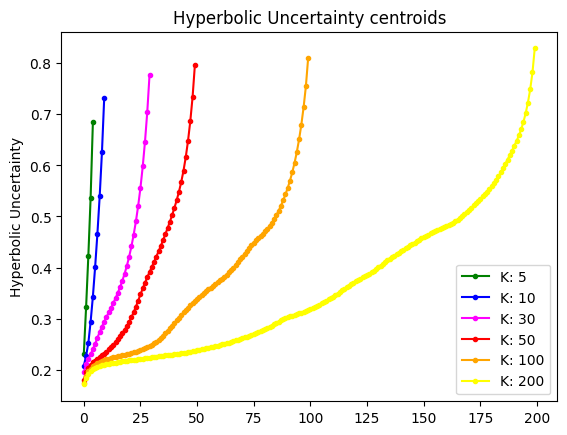

In [66]:
import matplotlib.pyplot as plt

# color_list = ['black', 'blue', 'olive', 'cyan', 'brown', 'green']
color_list_2 = ['green', 'blue', 'magenta', 'red', 'orange', 'yellow']

for idx, K in enumerate(save_dict.keys()):
    plt.plot(save_dict[K], '-o', markersize=3, label='K: '+str(K), c=color_list_2[idx])

# plt.ylim(0, 1)
plt.ylabel('Hyperbolic Uncertainty')
plt.title('Hyperbolic Uncertainty centroids')
plt.legend()
plt.savefig('hyperbolic_uncertainty_centroids.png', dpi=300)
plt.show()

In [67]:
save_dict

{5: tensor([0.2313, 0.3218, 0.4235, 0.5369, 0.6845]),
 10: tensor([0.2075, 0.2268, 0.2522, 0.2940, 0.3432, 0.4016, 0.4666, 0.5396, 0.6259,
         0.7324]),
 30: tensor([0.1954, 0.2101, 0.2205, 0.2300, 0.2400, 0.2508, 0.2625, 0.2739, 0.2844,
         0.2941, 0.3032, 0.3121, 0.3210, 0.3303, 0.3400, 0.3505, 0.3618, 0.3742,
         0.3880, 0.4035, 0.4211, 0.4413, 0.4644, 0.4909, 0.5213, 0.5565, 0.5979,
         0.6468, 0.7046, 0.7772]),
 50: tensor([0.1804, 0.1957, 0.2039, 0.2096, 0.2141, 0.2178, 0.2213, 0.2246, 0.2280,
         0.2316, 0.2355, 0.2397, 0.2442, 0.2490, 0.2540, 0.2594, 0.2651, 0.2713,
         0.2780, 0.2854, 0.2935, 0.3026, 0.3126, 0.3236, 0.3353, 0.3473, 0.3591,
         0.3703, 0.3810, 0.3912, 0.4012, 0.4112, 0.4214, 0.4319, 0.4427, 0.4539,
         0.4655, 0.4775, 0.4900, 0.5032, 0.5171, 0.5321, 0.5487, 0.5676, 0.5899,
         0.6165, 0.6486, 0.6872, 0.7340, 0.7958]),
 100: tensor([0.1743, 0.1883, 0.1967, 0.2023, 0.2065, 0.2098, 0.2127, 0.2150, 0.2171,
         0.218

In [71]:
save_dict2 = {k:v.tolist() for k, v in save_dict.items()}
save_dict2

{5: [0.23127388954162598,
  0.32178834080696106,
  0.4234561026096344,
  0.5368789434432983,
  0.6845219731330872],
 10: [0.20751120150089264,
  0.2268039584159851,
  0.252231627702713,
  0.2940138578414917,
  0.34324848651885986,
  0.4015769064426422,
  0.4666043817996979,
  0.539588212966919,
  0.6258973479270935,
  0.7323890328407288],
 30: [0.19537237286567688,
  0.210133895277977,
  0.22048796713352203,
  0.23003332316875458,
  0.2399694174528122,
  0.2508355677127838,
  0.26245543360710144,
  0.27390891313552856,
  0.2844359278678894,
  0.29406729340553284,
  0.3031598925590515,
  0.3120622932910919,
  0.32101520895957947,
  0.3302544355392456,
  0.34003278613090515,
  0.35048800706863403,
  0.3618060052394867,
  0.37421995401382446,
  0.38798031210899353,
  0.40348607301712036,
  0.4211188852787018,
  0.44130417704582214,
  0.464409202337265,
  0.49085313081741333,
  0.521262526512146,
  0.5564839243888855,
  0.5978789329528809,
  0.6467618942260742,
  0.7046095132827759,
  0.77

In [70]:
import json
json_dict = json.dumps(save_dict2)

f = open("kmeans/kmeans_30000.json","w")
f.write(json_dict)
f.close()

In [77]:
checkpoint_indices = [0, 7000, 14000, 22000, 30000]
save_dict = {}
K = 100

for checkpoint in checkpoint_indices:
    print(checkpoint)
    root_path = 'results/source_free/dlv3_hyper_v3plus_ch64_WN_5perc_certuncert_K100_mask3_LongRun/test/'+str(checkpoint)

    embed_path = root_path + '/embed'
    # pred_path = root_path + '/pred'
    # label_path = root_path + '/label'
    # output_path = root_path + '/output'

    embed_tensor = torch.load(os.path.join(root_path, 'embed_tensor.pt'))
    # pred_tensor = torch.load(os.path.join(root_path, 'pred_tensor.pt'))
    # label_tensor = torch.load(os.path.join(root_path, 'label_tensor.pt'))
    # output_tensor = torch.load(os.path.join(root_path, 'output_tensor.pt'))

    x = embed_tensor.norm(dim=1).reshape(-1,1)

    cluster_ids_x, cluster_centers = kmeans(X=x, num_clusters=K, distance='euclidean', device=torch.device('cuda:3'))
    save_dict[checkpoint] = cluster_centers.reshape(-1).sort().values


0
running k-means on cuda:3..


[running kmeans]: 50it [04:00,  4.82s/it, center_shift=0.000099, iteration=50, tol=0.000100]


7000
running k-means on cuda:3..


[running kmeans]: 35it [02:56,  5.04s/it, center_shift=0.000100, iteration=35, tol=0.000100]


14000
running k-means on cuda:3..


[running kmeans]: 44it [03:55,  5.35s/it, center_shift=0.000100, iteration=44, tol=0.000100]


22000
running k-means on cuda:3..


[running kmeans]: 43it [03:53,  5.42s/it, center_shift=0.000099, iteration=43, tol=0.000100]


30000
running k-means on cuda:3..


[running kmeans]: 19it [01:40,  5.28s/it, center_shift=0.000097, iteration=19, tol=0.000100]


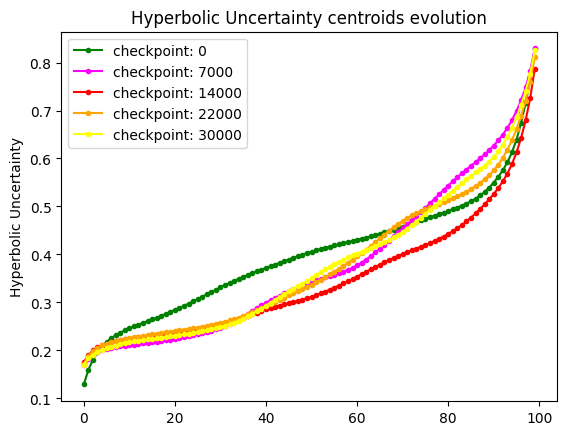

In [81]:
import matplotlib.pyplot as plt

# color_list = ['black', 'blue', 'olive', 'cyan', 'brown', 'green']
color_list_2 = ['green', 'magenta', 'red', 'orange', 'yellow']

for idx, checkpoint in enumerate(save_dict.keys()):
    plt.plot(save_dict[checkpoint], '-o', markersize=3, label='checkpoint: '+str(checkpoint), c=color_list_2[idx])

# plt.ylim(0, 1)
plt.ylabel('Hyperbolic Uncertainty')
plt.title('Hyperbolic Uncertainty centroids evolution')
plt.legend()
plt.savefig('kmeans/hyperbolic_uncertainty_centroids_evolutions.png', dpi=300)
plt.show()

In [79]:
save_dict_2 = {k:v.tolist() for k, v in save_dict.items()}

In [80]:
json_dict = json.dumps(save_dict_2)

f = open("kmeans/kmeans_dict.json","w")
f.write(json_dict)
f.close()

In [24]:
from kmeans_pytorch import kmeans

def quantize_uncertainty_map(embed_tensor, idx=0, K=100, device='cuda:1', size=(1024, 2048)):
    device = torch.device(device)
    
    unc_map = embed_tensor.norm(dim=1)
    unc_map_flatten = unc_map.reshape(-1,1)
    _, cluster_centers = kmeans(X=unc_map_flatten, num_clusters=K, distance='euclidean', device=device)
    values, _ = cluster_centers.reshape(-1).sort()

    unc_map_large = F.interpolate(unc_map[idx].unsqueeze(0).unsqueeze(0), size=size, mode='bilinear', align_corners=True).squeeze(1)
    unc_map_large_flatten = unc_map_large.reshape(-1,1)
    cluster_ids_x_sorted2 = torch.cdist(unc_map_large_flatten.reshape(1,-1, 1).float().to(device), values.reshape(1,-1, 1).float().to(device))
    _, indices_new = cluster_ids_x_sorted2.squeeze(0).min(dim=-1)

    return indices_new.reshape(*size, 1).long().to(unc_map.device)


def uniform_uncertainty_map(embed_tensor, idx=0, K=100, EPS=1e-5, device='cuda:2', size=(1024, 2048)):
    device = torch.device(device)
    
    unc_map = embed_tensor[idx].norm(dim=0).to(device)
    unc_map_large = F.interpolate(unc_map.unsqueeze(0).unsqueeze(0), size=size, mode='bilinear', align_corners=True).squeeze(1)

    unc_map_flatten = unc_map_large.reshape(-1,1)
    indices_new = (unc_map_flatten * K) - 0.5  # [h, w]
    indices_new = torch.clamp(indices_new, min=-0.5+EPS, max=K-0.5-EPS)
    indices_new = torch.round(indices_new)
    return indices_new.reshape(*size, 1).long().to(embed_tensor.device)

In [56]:
idx = 0
K = 200
quant_unc_map = quantize_uncertainty_map(embed_tensor, idx=idx, K=K, device='cuda:2')
unif_unc_map = uniform_uncertainty_map(embed_tensor, idx=idx, K=K, device='cuda:2')
unif_unc_map.shape

running k-means on cuda:2..


[running kmeans]: 31it [04:58,  9.63s/it, center_shift=0.000098, iteration=31, tol=0.000100]


torch.Size([1024, 2048, 1])

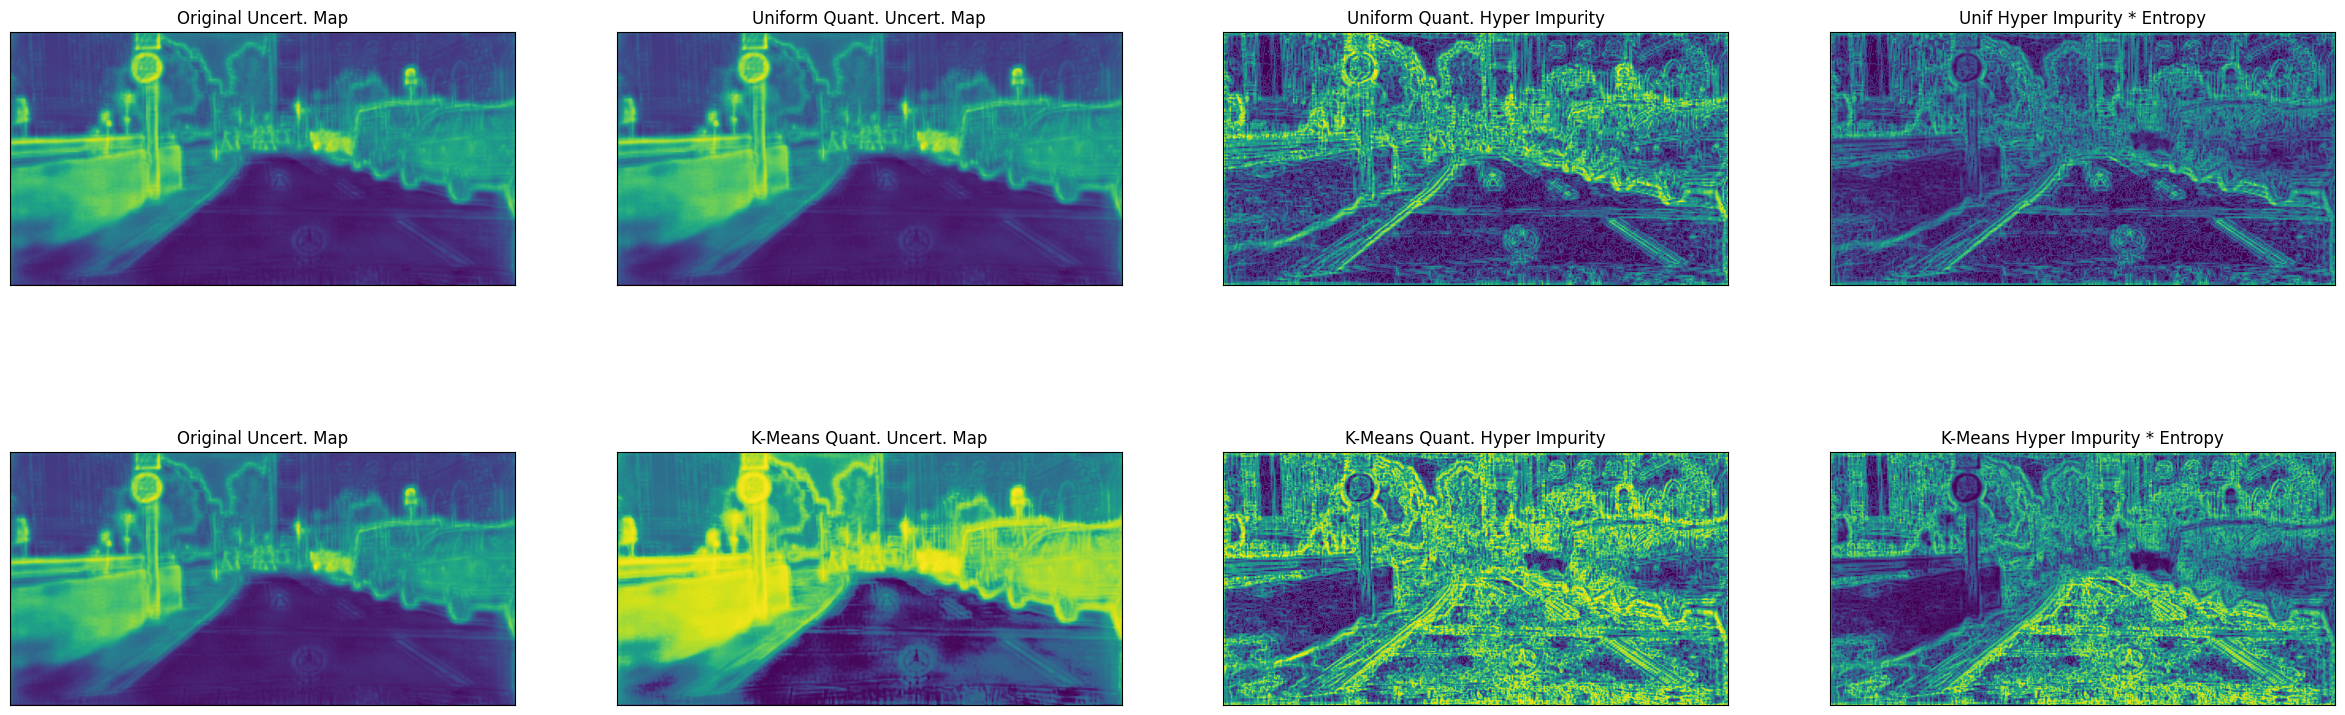

In [57]:
import matplotlib.pyplot as plt

floating_RA = FloatingRegionScore(in_channels=19, padding_mode='zeros', size=3, purity_type='hyper', K=K)

unc_map = embed_tensor[idx].norm(dim=0)
unc_map_large = F.interpolate(unc_map.unsqueeze(0).unsqueeze(0), size=(1024, 2048), mode='bilinear', align_corners=True).squeeze(0).squeeze(0)

output = F.interpolate(embed_tensor[idx].unsqueeze(0), size=(1024, 2048), mode='bilinear', align_corners=True)
score_unc, unif_hyp_imp, entr = floating_RA(output, decoder_out=unc_map_large.unsqueeze(0).unsqueeze(0), normalize=True, unc_type='entropy', pur_type='hyper')

unif_hyp_imp = floating_RA.compute_region_impurity(unif_unc_map.reshape(1024, 2048), K=K, normalize=True)[0].squeeze(0).squeeze(0)

plt, axes = plt.subplots(2,4, figsize=(30, 10))

axes[0,0].imshow(unc_map_large.cpu())
axes[0,0].xaxis.set_visible(False)
axes[0,0].yaxis.set_visible(False)
axes[0,0].set_title('Original Uncert. Map')

axes[0,1].imshow(unif_unc_map.cpu())
axes[0,1].xaxis.set_visible(False)
axes[0,1].yaxis.set_visible(False)
axes[0,1].set_title('Uniform Quant. Uncert. Map')

axes[0,2].imshow(unif_hyp_imp.cpu())
axes[0,2].xaxis.set_visible(False)
axes[0,2].yaxis.set_visible(False)
axes[0,2].set_title('Uniform Quant. Hyper Impurity')

axes[0,3].imshow(score_unc.cpu())
axes[0,3].xaxis.set_visible(False)
axes[0,3].yaxis.set_visible(False)
axes[0,3].set_title('Unif Hyper Impurity * Entropy')



quant_hyper_impurity = floating_RA.compute_region_impurity(quant_unc_map.reshape(1024, 2048), K=K, normalize=True)[0].squeeze(0).squeeze(0)
score_unc = quant_hyper_impurity * entr

axes[1,0].imshow(unc_map_large.cpu())
axes[1,0].xaxis.set_visible(False)
axes[1,0].yaxis.set_visible(False)
axes[1,0].set_title('Original Uncert. Map')

axes[1,1].imshow(quant_unc_map.cpu())
axes[1,1].xaxis.set_visible(False)
axes[1,1].yaxis.set_visible(False)
axes[1,1].set_title('K-Means Quant. Uncert. Map')

axes[1,2].imshow(quant_hyper_impurity.cpu())
axes[1,2].xaxis.set_visible(False)
axes[1,2].yaxis.set_visible(False)
axes[1,2].set_title('K-Means Quant. Hyper Impurity')

axes[1,3].imshow(score_unc.cpu())
axes[1,3].xaxis.set_visible(False)
axes[1,3].yaxis.set_visible(False)
axes[1,3].set_title('K-Means Hyper Impurity * Entropy')

plt.savefig('unif_vs_kmeans_hyper_impurity_K'+str(K)+'.png', dpi=300, bbox_inches='tight')

# Loading data

In [80]:
# root_path = 'results/source_target/dlv3_hyper_64_WN_2.2_cert_impur/test'
# root_path = 'results/source_target/dlv3_hyper_64_WN_2.2_cert_impur/test/0'
root_path = 'results/pretrain_gtav/v3plus_256/test'

embed_path = root_path + '/embed'
pred_path = root_path + '/pred'
label_path = root_path + '/label'
output_path = root_path + '/output'

In [56]:
embed_tensor = torch.load(os.path.join(root_path, 'embed_tensor.pt'))
pred_tensor = torch.load(os.path.join(root_path, 'pred_tensor.pt'))
label_tensor = torch.load(os.path.join(root_path, 'label_tensor.pt'))
output_tensor = torch.load(os.path.join(root_path, 'output_tensor.pt'))

print(embed_tensor.device)

FileNotFoundError: [Errno 2] No such file or directory: 'results/source_target/hyper_dlv3_64_WN_5_perc_entr_hyperimp_K100_RK5_no_consist/test/embed_tensor.pt'

In [83]:
EMBED_SIZE = 512

embed_tensor = torch.empty(0, EMBED_SIZE, 160, 320) 
pred_tensor = torch.empty(0, 160, 320) 
label_tensor = torch.empty(0, 160, 320)    
output_tensor = torch.empty(0, 19, 160, 320) 

# embed_tensor = torch.empty(0, 64, 1024, 2048) 
# pred_tensor = torch.empty(0, 1024, 2048) 
# label_tensor = torch.empty(0, 1024, 2048)    
# output_tensor = torch.empty(0, 19, 1024, 2048)

size = embed_tensor.shape[-2:]

for file_name in tqdm(os.listdir(embed_path)):

    embed = torch.load(os.path.join(embed_path, file_name))
    # embed = F.interpolate(embed.float(), size=size, mode='bilinear', align_corners=True)
    embed_tensor = torch.cat((embed_tensor, embed.cpu()), dim=0)

    pred = torch.load(os.path.join(pred_path, file_name))
    pred = F.interpolate(pred.unsqueeze(0).float(), size=size, mode='nearest')
    pred_tensor = torch.cat((pred_tensor, pred.squeeze(0).cpu()), dim=0)

    label = torch.load(os.path.join(label_path, file_name))
    label = F.interpolate(label.unsqueeze(0).float(), size=size, mode='nearest')
    label_tensor = torch.cat((label_tensor, label.squeeze(0).cpu()), dim=0)

    output = torch.load(os.path.join(output_path, file_name))
    output = F.interpolate(output.float(), size=size, mode='nearest')
    output_tensor = torch.cat((output_tensor, output.cpu()), dim=0)


100%|██████████| 130/130 [01:59<00:00,  1.09it/s]


In [ ]:
checkpoint_to_load = [7000, 14000, 22000, 30000]

for i in checkpoint_to_load:

    root_path = 'results/source_free/dlv3_hyper_v3plus_ch64_WN_5perc_certuncert_K100_mask3_LongRun/test/'+str(i)
    embed_path = root_path + '/embed'
    pred_path = root_path + '/pred'
    label_path = root_path + '/label'
    output_path = root_path + '/output'

    embed_tensor = torch.empty(0, 64, 160, 320) 
    pred_tensor = torch.empty(0, 160, 320) 
    label_tensor = torch.empty(0, 160, 320)    
    output_tensor = torch.empty(0, 19, 160, 320) 

    size = embed_tensor.shape[-2:]

    for file_name in tqdm(os.listdir(embed_path)):

        embed = torch.load(os.path.join(embed_path, file_name))
        # embed = F.interpolate(embed.float(), size=size, mode='bilinear', align_corners=True)
        embed_tensor = torch.cat((embed_tensor, embed.cpu()), dim=0)

        pred = torch.load(os.path.join(pred_path, file_name))
        pred = F.interpolate(pred.unsqueeze(0).float(), size=size, mode='nearest')
        pred_tensor = torch.cat((pred_tensor, pred.squeeze(0).cpu()), dim=0)

        label = torch.load(os.path.join(label_path, file_name))
        label = F.interpolate(label.unsqueeze(0).float(), size=size, mode='nearest')
        label_tensor = torch.cat((label_tensor, label.squeeze(0).cpu()), dim=0)

        output = torch.load(os.path.join(output_path, file_name))
        output = F.interpolate(output.float(), size=size, mode='nearest')
        output_tensor = torch.cat((output_tensor, output.cpu()), dim=0)
    
    torch.save(embed_tensor, os.path.join(root_path, 'embed_tensor.pt'))
    torch.save(pred_tensor, os.path.join(root_path, 'pred_tensor.pt'))
    torch.save(label_tensor, os.path.join(root_path, 'label_tensor.pt'))
    torch.save(output_tensor, os.path.join(root_path, 'output_tensor.pt'))


In [84]:
torch.save(embed_tensor, os.path.join(root_path, 'embed_tensor.pt'))
torch.save(pred_tensor, os.path.join(root_path, 'pred_tensor.pt'))
torch.save(label_tensor, os.path.join(root_path, 'label_tensor.pt'))
torch.save(output_tensor, os.path.join(root_path, 'output_tensor.pt'))

In [ ]:
embed_tensor = torch.load(os.path.join(root_path, 'embed_tensor.pt')).to('cuda:0')
pred_tensor = torch.load(os.path.join(root_path, 'pred_tensor.pt')).to('cuda:0')
label_tensor = torch.load(os.path.join(root_path, 'label_tensor.pt')).to('cuda:0')
output_tensor = torch.load(os.path.join(root_path, 'output_tensor.pt')).to('cuda:0')

print(embed_tensor.device)

In [ ]:
# Check Min, Max, Mean Radius
embed_tensor_norm = torch.norm(embed_tensor, dim=1, keepdim=False)
all_norm = embed_tensor_norm.flatten()
all_norm.min().item(), all_norm.max().item(), all_norm.mean().item()

In [ ]:
img_list = os.listdir(embed_path)
name = img_list[idx][:-3]

img = Image.open(os.path.join('datasets/cityscapes/leftImg8bit/val/', img_list[idx].split('_')[0], img_list[idx][:-3] + '_leftImg8bit.png'))
img = img.resize((320, 160), Image.NEAREST)
img

# Correlation plots

In [ ]:

output_sel = output_tensor[idx].unsqueeze(0)
embed_sel = embed_tensor[idx].unsqueeze(0)

_, impurity, entropy = floating_region_score(output_sel, decoder_out=embed_sel, normalize=True, unc_type='entropy', pur_type='ripu')
_, _, hyp_uncert = floating_region_score(output_sel, decoder_out=embed_sel, normalize=True, unc_type='hyperbolic', pur_type='ripu')
hyp_cert = 1 - hyp_uncert
ent_cert = 1 - entropy



color_list = [extract_color(c) for c in pred_tensor[idx].reshape(-1).tolist()]

fig = plt.figure(figsize=(10, 10), clear=True)
ax = fig.add_subplot(111)

scatter1 = ax.scatter(hyp_uncert.reshape(-1), entropy.reshape(-1), c=color_list, alpha=.6, s=7)



ax.set_xlabel('Hyperbolic Uncertainty')
ax.set_ylabel('Entropy')
ax.set_title('Hyperbolic Uncertainty vs Entropy\n'+name)

ax.set_yscale('log')
# ax.set_xlim(0, 1)
# ax.set_ylim(0, 1)
# plt.gca().set_xscale("functionlog", functions=[lambda x: x, lambda x: scale_f(x)])


patchList = extract_legend()
plt.legend(handles=patchList, loc='center left', bbox_to_anchor=(1, 0.5), title="Classes")
plt.savefig('./visualizzazioni/'+name+'_ent_vs_hyp.png')

In [ ]:
# idx = 0

output_sel = output_tensor[idx].unsqueeze(0)
embed_sel = embed_tensor[idx].unsqueeze(0)

mask_known = label_tensor[idx] != 255
mask_correct = pred_tensor[idx] == label_tensor[idx]
mask_uncorrect = pred_tensor[idx] != label_tensor[idx]
mask_correct = mask_correct & mask_known
mask_uncorrect = mask_uncorrect & mask_known
# mask = torch.ones_like(pred_tensor[idx])

mask_correct = mask_correct.reshape(-1)
mask_uncorrect = mask_uncorrect.reshape(-1)

_, impurity, entropy = floating_region_score(output_sel, decoder_out=embed_sel, normalize=True, unc_type='entropy', pur_type='ripu')
_, _, hyp_uncert = floating_region_score(output_sel, decoder_out=embed_sel, normalize=True, unc_type='hyperbolic', pur_type='ripu')
hyp_cert = 1 - hyp_uncert
ent_cert = 1 - entropy

# pred_flatten = pred_tensor[idx].reshape(-1)
# pred_correct = pred_flatten[mask_correct]
# color_list = [extract_color(c) for c in pred_correct.tolist()]

label_flatten = label_tensor[idx].reshape(-1)
label_correct = label_flatten[mask_correct]
color_list = [extract_color(c) for c in label_correct.tolist()]

fig, axes = plt.subplots(2, 2, figsize=(12, 10), constrained_layout = True) # constrained_layout = True

# fig = plt.figure(figsize=(10, 10), clear=True)
# ax1, ax2 = fig.add_subplot(1,2)

hyp_uncert_correct = hyp_uncert.reshape(-1)[mask_correct]
entropy_correct = entropy.reshape(-1)[mask_correct]
scatter1 = axes[0,0].scatter(hyp_uncert_correct, entropy_correct, c=color_list, alpha=.6, s=7)

axes[0,0].set_yscale('log')
axes[0,0].set_xlim(0, 1)
# axes[0,0].set_ylim(0, 1)
axes[0,0].set_xlabel('Hyperbolic Uncertainty')
axes[0,0].set_ylabel('Entropy')
axes[0,0].set_title('Correct Prediction')



# pred_uncorrect = pred_flatten[mask_uncorrect]
# color_list = [extract_color(c) for c in pred_uncorrect.tolist()]

label_uncorrect = label_flatten[mask_uncorrect]
color_list = [extract_color(c) for c in label_uncorrect.tolist()]

hyp_uncert_uncorrect = hyp_uncert.reshape(-1)[mask_uncorrect]
entropy_uncorrect = entropy.reshape(-1)[mask_uncorrect]
scatter1 = axes[0,1].scatter(hyp_uncert_uncorrect, entropy_uncorrect, c=color_list, alpha=.6, s=7)

axes[0,1].set_yscale('log')
axes[0,1].set_xlim(0, 1)
# axes[0,1].set_ylim(0, 1)
axes[0,1].set_xlabel('Hyperbolic Uncertainty')
axes[0,1].set_ylabel('Entropy')
axes[0,1].set_title('Uncorrect Prediction')


patchList = extract_legend()
axes[0,1].legend(handles=patchList, loc='center left', bbox_to_anchor=(1, 0.5), title="Classes")




mask_known = label_tensor[idx] != 255
mask_correct = label_tensor[idx] == pred_tensor[idx]
total_mask = mask_known & mask_correct
total_mask = total_mask.cpu().numpy() * 1.

# pred_np_image = np.asarray(get_color_pallete(pred_tensor[idx].cpu().numpy()))

axes[1,0].set_title('Correct Prediction')
# axes[1,0].imshow(label_tensor[idx])
label_correct = pred_tensor[idx].cpu().numpy()*total_mask + 255*(1-total_mask)
im_score = axes[1,0].imshow(get_color_pallete(label_correct), alpha=1.)
axes[1,0].xaxis.set_visible(False)
axes[1,0].yaxis.set_visible(False)

mask_uncorrect = label_tensor[idx] != pred_tensor[idx]
total_mask = mask_known & mask_uncorrect
total_mask = total_mask.cpu().numpy() * 1.

axes[1,1].set_title('Uncorrect Prediction')
# axes[1,1].imshow(label_tensor[idx])
label_uncorrect = pred_tensor[idx].cpu().numpy()*total_mask + 255*(1-total_mask)
im_score = axes[1,1].imshow(get_color_pallete(label_uncorrect), alpha=1.)
axes[1,1].xaxis.set_visible(False)
axes[1,1].yaxis.set_visible(False)


fig.suptitle(name)
plt.savefig('./visualizzazioni/'+name+'_ent_vs_hyp_corr_uncorr.png')

In [ ]:
most_frequent_class = [0, 1, 2, 8, 10, 13]


idx = 6
output_sel = output_tensor[idx].unsqueeze(0)
embed_sel = embed_tensor[idx].unsqueeze(0)


_, impurity, entropy = floating_region_score(output_sel, decoder_out=embed_sel, normalize=True, unc_type='entropy', pur_type='ripu')
_, _, hyp_uncert = floating_region_score(output_sel, decoder_out=embed_sel, normalize=True, unc_type='hyperbolic', pur_type='ripu')
hyp_cert = 1 - hyp_uncert
ent_cert = 1 - entropy



mask_correct = pred_tensor[idx] == label_tensor[idx]
total_mask = pred_tensor[idx] != label_tensor[idx]
mask_correct = mask_correct.reshape(-1)
mask_uncorrect = mask_uncorrect.reshape(-1)

label_flatten = label_tensor[idx].reshape(-1)

mask_known = label_flatten != 255.

mask_most_frequent = sum(label_flatten==i for i in most_frequent_class).bool()
mask_less_frequent = ~mask_most_frequent




fig, axes = plt.subplots(3, 2, figsize=(12, 15), constrained_layout = True) # constrained_layout = True


total_mask = mask_known & mask_correct & mask_most_frequent
label_correct = label_flatten[total_mask]
color_list = [extract_color(c) for c in label_correct.tolist()]

hyp_uncert_correct = hyp_uncert.reshape(-1)[total_mask]
entropy_correct = entropy.reshape(-1)[total_mask]
scatter1 = axes[0,0].scatter(hyp_uncert_correct, entropy_correct, c=color_list, alpha=.6, s=7)

axes[0,0].set_yscale('log')
axes[0,0].set_xlim(0, 1)
axes[0,0].set_ylim(1e-5, 1.)
axes[0,0].set_xlabel('Hyperbolic Uncertainty')
axes[0,0].set_ylabel('Entropy')
axes[0,0].set_title('Correct Prediction')


total_mask = mask_known & mask_uncorrect & mask_most_frequent
label_uncorrect = label_flatten[total_mask]
color_list = [extract_color(c) for c in label_uncorrect.tolist()]

hyp_uncert_uncorrect = hyp_uncert.reshape(-1)[total_mask]
entropy_uncorrect = entropy.reshape(-1)[total_mask]
scatter1 = axes[0,1].scatter(hyp_uncert_uncorrect, entropy_uncorrect, c=color_list, alpha=.6, s=7)

axes[0,1].set_yscale('log')
axes[0,1].set_xlim(0., 1.)
axes[0,1].set_ylim(1e-5, 1.)
axes[0,1].set_xlabel('Hyperbolic Uncertainty')
axes[0,1].set_ylabel('Entropy')
axes[0,1].set_title('Uncorrect Prediction')

patchList = extract_legend(frequent='most')
axes[0,1].legend(handles=patchList, loc='center left', bbox_to_anchor=(1, 0.5), title="Most Freq.\n  Classes")


total_mask = mask_known & mask_correct & mask_less_frequent
label_correct = label_flatten[total_mask]
color_list = [extract_color(c) for c in label_correct.tolist()]

hyp_uncert_correct = hyp_uncert.reshape(-1)[total_mask]
entropy_correct = entropy.reshape(-1)[total_mask]
scatter3 = axes[1,0].scatter(hyp_uncert_correct, entropy_correct, c=color_list, alpha=.6, s=7)

axes[1,0].set_yscale('log')
axes[1,0].set_xlim(0, 1)
axes[1,0].set_ylim(1e-5, 1.)
axes[1,0].set_xlabel('Hyperbolic Uncertainty')
axes[1,0].set_ylabel('Entropy')
axes[1,0].set_title('Correct Prediction')


total_mask = mask_known & mask_uncorrect & mask_less_frequent
label_uncorrect = label_flatten[total_mask]
color_list = [extract_color(c) for c in label_uncorrect.tolist()]

hyp_uncert_uncorrect = hyp_uncert.reshape(-1)[total_mask]
entropy_uncorrect = entropy.reshape(-1)[total_mask]
scatter4 = axes[1,1].scatter(hyp_uncert_uncorrect, entropy_uncorrect, c=color_list, alpha=.6, s=7)

axes[1,1].set_yscale('log')
axes[1,1].set_xlim(0, 1)
axes[1,1].set_ylim(1e-5, 1.)
axes[1,1].set_xlabel('Hyperbolic Uncertainty')
axes[1,1].set_ylabel('Entropy')
axes[1,1].set_title('Uncorrect Prediction')

patchList = extract_legend(frequent='less')
axes[1,1].legend(handles=patchList, loc='center left', bbox_to_anchor=(1, 0.5), title="Less Freq.\n  Classes")




mask_known = label_tensor[idx] != 255
mask_correct = label_tensor[idx] == pred_tensor[idx]
total_mask = mask_known & mask_correct
total_mask = total_mask.cpu().numpy() * 1.

# pred_np_image = np.asarray(get_color_pallete(pred_tensor[idx].cpu().numpy()))

axes[2,0].set_title('Correct Prediction')
# axes[2,0].imshow(label_tensor[idx])
label_correct = pred_tensor[idx].cpu().numpy()*total_mask + 255*(1-total_mask)
im_score = axes[2,0].imshow(get_color_pallete(label_correct), alpha=1.)
axes[2,0].xaxis.set_visible(False)
axes[2,0].yaxis.set_visible(False)

mask_uncorrect = label_tensor[idx] != pred_tensor[idx]
total_mask = mask_known & mask_uncorrect
total_mask = total_mask.cpu().numpy() * 1.

axes[2,1].set_title('Uncorrect Prediction')
# axes[2,1].imshow(label_tensor[idx])
label_uncorrect = pred_tensor[idx].cpu().numpy()*total_mask + 255*(1-total_mask)
im_score = axes[2,1].imshow(get_color_pallete(label_uncorrect), alpha=1.)
axes[2,1].xaxis.set_visible(False)
axes[2,1].yaxis.set_visible(False)


fig.suptitle(name)
plt.savefig('./visualizzazioni/'+name+'_ent_vs_hyp_most_less_freq.png')

# Score Plots

In [ ]:
# idx = 0
output_sel = output_tensor[idx].unsqueeze(0)
embed_sel = embed_tensor[idx].unsqueeze(0)

_, impurity, entropy = floating_region_score(output_sel, decoder_out=embed_sel, normalize=True, unc_type='entropy', pur_type='ripu')
_, _, hyp_uncert = floating_region_score(output_sel, decoder_out=embed_sel, normalize=True, unc_type='hyperbolic', pur_type='ripu')
hyp_cert = 1 - hyp_uncert
ent_cert = 1 - entropy

score = entropy * impurity

img_list = os.listdir(embed_path)
img = Image.open(os.path.join('datasets/cityscapes/leftImg8bit/val/', img_list[idx].split('_')[0], img_list[idx][:-3] + '_leftImg8bit.png'))
img = img.resize((entropy.shape[-1],entropy.shape[-2]), Image.NEAREST)


In [ ]:
cmap1 = 'gray'
cmap2 = 'viridis'
alpha = 0.6

score_np = score.cpu().numpy()
entropy_np = entropy.cpu().numpy()
hypunc_np = hyp_uncert.cpu().numpy()
hypcert_np = hyp_cert.cpu().numpy()
impurity_np = impurity.cpu().numpy()

fig, axes = plt.subplots(4, 3, figsize=(10, 10), constrained_layout = True) # constrained_layout = True


axes[0,0].set_title('Hyper Uncertainty')
axes[0,0].imshow(img, cmap=cmap1)
im_score = axes[0,0].imshow(hypunc_np,  cmap=cmap2, alpha=alpha)
axes[0,0].xaxis.set_visible(False)
axes[0,0].yaxis.set_visible(False)

axes[1,0].set_title('Entropy')
axes[1,0].imshow(img, cmap=cmap1)
im_score = axes[1,0].imshow(entropy_np,  cmap=cmap2, alpha=alpha)
axes[1,0].xaxis.set_visible(False)
axes[1,0].yaxis.set_visible(False)

axes[2,0].set_title('Impurity')
axes[2,0].imshow(img, cmap=cmap1)
im_score = axes[2,0].imshow(impurity_np,  cmap=cmap2, alpha=alpha)
axes[2,0].xaxis.set_visible(False)
axes[2,0].yaxis.set_visible(False)

axes[3,0].set_title('Hyper Certainty')
axes[3,0].imshow(img, cmap=cmap1)
im_score = axes[3,0].imshow(hypcert_np,  cmap=cmap2, alpha=alpha)
axes[3,0].xaxis.set_visible(False)
axes[3,0].yaxis.set_visible(False)



# Plots for correct predictions only
mask_known = label_tensor[idx] != 255
mask_correct = label_tensor[idx] == pred_tensor[idx]
total_mask = mask_known & mask_correct
total_mask = total_mask.cpu().numpy() * 1.

axes[0,1].set_title('Hyper Uncertainty\n Correct')
axes[0,1].imshow(img, cmap=cmap1)
im_score = axes[0,1].imshow(hypunc_np*total_mask,  cmap=cmap2, alpha=alpha)
axes[0,1].xaxis.set_visible(False)
axes[0,1].yaxis.set_visible(False)

axes[1,1].set_title('Entropy\n Correct')
axes[1,1].imshow(img, cmap=cmap1)
im_score = axes[1,1].imshow(entropy_np*total_mask,  cmap=cmap2, alpha=alpha)
axes[1,1].xaxis.set_visible(False)
axes[1,1].yaxis.set_visible(False)

axes[2,1].set_title('Impurity\n Correct')
axes[2,1].imshow(img, cmap=cmap1)
im_score = axes[2,1].imshow(impurity_np*total_mask,  cmap=cmap2, alpha=alpha)
axes[2,1].xaxis.set_visible(False)
axes[2,1].yaxis.set_visible(False)

axes[3,1].set_title('Hyper Certainty\n Correct')
axes[3,1].imshow(img, cmap=cmap1)
im_score = axes[3,1].imshow(hypcert_np*total_mask,  cmap=cmap2, alpha=alpha)
axes[3,1].xaxis.set_visible(False)
axes[3,1].yaxis.set_visible(False)


# Plots for uncorrect predictions only
mask_known = label_tensor[idx] != 255
mask_uncorrect = label_tensor[idx] != pred_tensor[idx]
total_mask = mask_known & mask_uncorrect
total_mask = total_mask.cpu().numpy() * 1.

axes[0,2].set_title('Hyper Uncertainty\n Uncorrect')
axes[0,2].imshow(img, cmap=cmap1)
im_score = axes[0,2].imshow(hypunc_np*total_mask,  cmap=cmap2, alpha=alpha)
axes[0,2].xaxis.set_visible(False)
axes[0,2].yaxis.set_visible(False)

axes[1,2].set_title('Entropy\n Uncorrect')
axes[1,2].imshow(img, cmap=cmap1)
im_score = axes[1,2].imshow(entropy_np*total_mask,  cmap=cmap2, alpha=alpha)
axes[1,2].xaxis.set_visible(False)
axes[1,2].yaxis.set_visible(False)

axes[2,2].set_title('Impurity\n Uncorrect')
axes[2,2].imshow(img, cmap=cmap1)
im_score = axes[2,2].imshow(impurity_np*total_mask,  cmap=cmap2, alpha=alpha)
axes[2,2].xaxis.set_visible(False)
axes[2,2].yaxis.set_visible(False)

axes[3,2].set_title('Hyper Certainty\n Uncorrect')
axes[3,2].imshow(img, cmap=cmap1)
im_score = axes[3,2].imshow(hypcert_np*total_mask,  cmap=cmap2, alpha=alpha)
axes[3,2].xaxis.set_visible(False)
axes[3,2].yaxis.set_visible(False)



fig.suptitle(name)
plt.savefig('./visualizzazioni/'+name+'_all_scores_corr_uncorr.png')



# Histogram error vs certainty gap

## single sample

In [ ]:
idx = 1

In [ ]:
output_sel = output_tensor[idx].unsqueeze(0)
embed_sel = embed_tensor[idx].unsqueeze(0)

_, impurity, entropy = floating_region_score(output_sel, decoder_out=embed_sel, normalize=True, unc_type='entropy', pur_type='ripu')
_, _, hyp_uncert = floating_region_score(output_sel, decoder_out=embed_sel, normalize=True, unc_type='hyperbolic', pur_type='ripu')
hyp_cert = 1 - hyp_uncert
ent_cert = 1 - entropy

In [ ]:
# flatten all the tensors
impurity_flatten = impurity.reshape(-1)
entropy_flatten = entropy.reshape(-1)
hyp_uncert_flatten = hyp_uncert.reshape(-1)
hyp_cert_flatten = hyp_cert.reshape(-1)

label_tensor_flatten = label_tensor[idx].reshape(-1)
pred_tensor_flatten = pred_tensor[idx].reshape(-1)

mask_known = label_tensor_flatten != 255
mask_correct = label_tensor_flatten == pred_tensor_flatten
mask_uncorrect = label_tensor_flatten != pred_tensor_flatten

In [ ]:
impurity_correct = impurity_flatten[mask_known & mask_correct]
entropy_correct = entropy_flatten[mask_known & mask_correct]
hyp_uncert_correct = hyp_uncert_flatten[mask_known & mask_correct]
hyp_cert_correct = hyp_cert_flatten[mask_known & mask_correct]

impurity_uncorrect = impurity_flatten[mask_known & mask_uncorrect]
entropy_uncorrect = entropy_flatten[mask_known & mask_uncorrect]
hyp_uncert_uncorrect = hyp_uncert_flatten[mask_known & mask_uncorrect]
hyp_cert_uncorrect = hyp_cert_flatten[mask_known & mask_uncorrect]

In [ ]:
num_per_range_uncorr,_,_ = plt.hist(hyp_cert_uncorrect, bins=np.arange(-0.05,1.1,0.1), edgecolor='black', rwidth=0.8)
plt.xticks(np.arange(0,1.1,0.1))
plt.ylabel("# Errors")
plt.xlabel("Hyper Certainty")
plt.title("Uncorrect Prediction for different Hyperbolic certainty ranges")
plt.show()

In [ ]:
num_per_range,_,_ = plt.hist(hyp_cert_flatten[mask_known], bins=np.arange(-0.05,1.1,0.1), edgecolor='black', rwidth=0.8)
num_per_range_uncorr,_,_ = plt.hist(hyp_cert_uncorrect, bins=np.arange(-0.05,1.1,0.1), edgecolor='black', rwidth=0.8)
num_per_range_corr,_,_ = plt.hist(hyp_cert_correct, bins=np.arange(-0.05,1.1,0.1), edgecolor='black', rwidth=0.8)
plt.close()

freq_per_range_corr = num_per_range_corr/num_per_range
plt.bar(np.arange(0, 1.1, 0.1), freq_per_range_corr, width = 0.08, color='tab:blue', edgecolor='black', alpha=0.8, label='Correct')

freq_per_range_uncorr = num_per_range_uncorr/num_per_range
plt.bar(np.arange(0, 1.1, 0.1), freq_per_range_uncorr, width = 0.08, color='red', edgecolor='black', alpha=0.6, label='Incorrect')

plt.xticks(np.arange(0,1.1,0.1))
plt.ylabel("% Correctness")
plt.xlabel("Hyper Certainty")
plt.title("Correctness% for different Hyperbolic certainty ranges")
plt.legend()
plt.show()

In [ ]:
num_per_range,_,_ = plt.hist(entropy_flatten[mask_known], bins=np.arange(-0.05,1.1,0.1), edgecolor='black', rwidth=0.8)
num_per_range_uncorr,_,_ = plt.hist(entropy_uncorrect, bins=np.arange(-0.05,1.1,0.1), edgecolor='black', rwidth=0.8)
num_per_range_corr,_,_ = plt.hist(entropy_correct, bins=np.arange(-0.05,1.1,0.1), edgecolor='black', rwidth=0.8)
plt.close()


freq_per_range_corr = num_per_range_corr/num_per_range
plt.bar(np.arange(0, 1.1, 0.1), freq_per_range_corr, width = 0.08, color='tab:blue', edgecolor='black', alpha=0.7, label='Correct')

freq_per_range_uncorr = num_per_range_uncorr/num_per_range
plt.bar(np.arange(0, 1.1, 0.1), freq_per_range_uncorr, width = 0.08, color='red', edgecolor='black', alpha=0.7, label='Incorrect')

plt.xticks(np.arange(0,1.1,0.1))
plt.ylabel("% Correctness")
plt.xlabel("Hyper Entropy")
plt.title(r"Correctness% for different Entropy ranges")
plt.legend()

# plt.savefig('./visualizzazioni/error_perc_hist_for_entropy_ranges.png')
plt.show()

In [ ]:
num_per_range,_,_ = plt.hist(impurity_flatten[mask_known], bins=np.arange(-0.05,1.1,0.1), edgecolor='black', rwidth=0.8)
num_per_range_uncorr,_,_ = plt.hist(impurity_uncorrect, bins=np.arange(-0.05,1.1,0.1), edgecolor='black', rwidth=0.8)
num_per_range_corr,_,_ = plt.hist(impurity_correct, bins=np.arange(-0.05,1.1,0.1), edgecolor='black', rwidth=0.8)
plt.close()


freq_per_range_corr = num_per_range_corr/num_per_range
plt.bar(np.arange(0, 1.1, 0.1), freq_per_range_corr, width = 0.08, color='tab:blue', edgecolor='black', alpha=0.7, label='Correct')

freq_per_range_uncorr = num_per_range_uncorr/num_per_range
plt.bar(np.arange(0, 1.1, 0.1), freq_per_range_uncorr, width = 0.08, color='red', edgecolor='black', alpha=0.7, label='Incorrect')

plt.xticks(np.arange(0,1.1,0.1))
plt.ylabel("% Correctness")
plt.xlabel("Hyper Certainty")
plt.title(r"Correctness% for different Impurity ranges")
plt.legend()

# plt.savefig('./visualizzazioni/error_perc_hist_for_entropy_ranges.png')
plt.show()

In [ ]:
plt.hist(entropy_uncorrect, bins=np.arange(-0.05,1.1,0.1), edgecolor='black', rwidth=0.8) # 
plt.xticks(np.arange(0,1.1,0.1))
plt.ylabel("# Errors")
plt.xlabel("Entropy")
plt.title("Uncorrect Prediction for different Entropy ranges")
plt.show()

In [ ]:
plt.hist(impurity_uncorrect, bins=np.arange(-0.05,1.1,0.1), edgecolor='black', rwidth=0.8) # 
plt.xticks(np.arange(0,1.1,0.1))
plt.ylabel("# Errors")
plt.xlabel("Impurity")
plt.title("Uncorrect Prediction for different Impurity ranges")
plt.show()

## All data

In [ ]:
impurity_all = torch.empty(0, 160, 320)
entropy_all = torch.empty(0, 160, 320)
hypunc_all = torch.empty(0, 160, 320)
hyp_cert_all = torch.empty(0, 160, 320)

for idx in tqdm(range(500)):
    output_sel = output_tensor[idx].unsqueeze(0)
    embed_sel = embed_tensor[idx].unsqueeze(0)

    _, impurity, entropy = floating_region_score(output_sel, decoder_out=embed_sel, normalize=True, unc_type='entropy', pur_type='ripu')
    _, _, hyp_uncert = floating_region_score(output_sel, decoder_out=embed_sel, normalize=True, unc_type='hyperbolic', pur_type='ripu')
    hyp_cert = 1 - hyp_uncert
    # ent_cert = 1 - entropy
    impurity_all = torch.cat((impurity_all, impurity.unsqueeze(0)), dim=0)
    entropy_all = torch.cat((entropy_all, entropy.unsqueeze(0)), dim=0)
    hypunc_all = torch.cat((hypunc_all, hyp_uncert.unsqueeze(0)), dim=0)
    hyp_cert_all = torch.cat((hyp_cert_all, hyp_cert.unsqueeze(0)), dim=0)

In [ ]:
# flatten all the tensors
impurity_flatten = impurity_all.reshape(-1)
entropy_flatten = entropy_all.reshape(-1)
hyp_uncert_flatten = hypunc_all.reshape(-1)
hyp_cert_flatten = hyp_cert_all.reshape(-1)

label_tensor_flatten = label_tensor.reshape(-1)
pred_tensor_flatten = pred_tensor.reshape(-1)

mask_known = label_tensor_flatten != 255
mask_correct = label_tensor_flatten == pred_tensor_flatten
mask_uncorrect = label_tensor_flatten != pred_tensor_flatten

In [ ]:
impurity_correct = impurity_flatten[mask_known & mask_correct]
entropy_correct = entropy_flatten[mask_known & mask_correct]
hyp_uncert_correct = hyp_uncert_flatten[mask_known & mask_correct]
hyp_cert_correct = hyp_cert_flatten[mask_known & mask_correct]

impurity_uncorrect = impurity_flatten[mask_known & mask_uncorrect]
entropy_uncorrect = entropy_flatten[mask_known & mask_uncorrect]
hyp_uncert_uncorrect = hyp_uncert_flatten[mask_known & mask_uncorrect]
hyp_cert_uncorrect = hyp_cert_flatten[mask_known & mask_uncorrect]

## Not Normalized

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), constrained_layout = True) # constrained_layout = True

ax1.hist(hyp_cert_uncorrect, bins=np.arange(-0.05,1.1,0.1), edgecolor='black', rwidth=0.8)
ax1.set_xticks(np.arange(0,1.1,0.1))
ax1.set_ylabel("# Uncorrect Predictions")
ax1.set_xlabel("Hyper Certainty")
ax1.set_title("Uncorrect Prediction Histogram\nfor different Hyperbolic certainty ranges")

ax2.hist(hyp_cert_correct, bins=np.arange(-0.05,1.1,0.1), edgecolor='black', rwidth=0.8)
ax2.set_xticks(np.arange(0,1.1,0.1))
ax2.set_ylabel("# Correct Predictions")
ax2.set_xlabel("Hyper Certainty")
ax2.set_title("Correct Prediction Histogram\nfor different Hyperbolic certainty ranges")

plt.savefig('./visualizzazioni/error_freq_hist_for_certainty_ranges.png')
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), constrained_layout = True) # constrained_layout = True

ax1.hist(entropy_uncorrect, bins=np.arange(-0.05,1.1,0.1), edgecolor='black', rwidth=0.8)
ax1.set_xticks(np.arange(0,1.1,0.1))
ax1.set_ylabel("# Uncorrect Predictions")
ax1.set_xlabel("Entropy")
ax1.set_title("Uncorrect Prediction Histogram\nfor different Entropy ranges")

ax2.hist(entropy_correct, bins=np.arange(-0.05,1.1,0.1), edgecolor='black', rwidth=0.8)
ax2.set_xticks(np.arange(0,1.1,0.1))
ax2.set_ylabel("# Correct Predictions")
ax2.set_xlabel("Entropy")
ax2.set_title("Correct Prediction Histogram\nfor different Entropy ranges")

plt.savefig('./visualizzazioni/error_freq_hist_for_entropy_ranges.png')
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), constrained_layout = True) # constrained_layout = True

ax1.hist(impurity_uncorrect, bins=np.arange(-0.05,1.1,0.1), edgecolor='black', rwidth=0.8)
ax1.set_xticks(np.arange(0,1.1,0.1))
ax1.set_ylabel("# Uncorrect Predictions")
ax1.set_xlabel("Impurity")
ax1.set_title("Uncorrect Prediction Histogram\nfor different Impurity ranges")

ax2.hist(impurity_correct, bins=np.arange(-0.05,1.1,0.1), edgecolor='black', rwidth=0.8)
ax2.set_xticks(np.arange(0,1.1,0.1))
ax2.set_ylabel("# Correct Predictions")
ax2.set_xlabel("Impurity")
ax2.set_title("Correct Prediction Histogram\nfor different Impurity ranges")

plt.savefig('./visualizzazioni/error_freq_hist_for_impurity_ranges.png')
plt.show()

## Normalized

In [ ]:
num_per_range,_,_ = plt.hist(hyp_cert_flatten[mask_known], bins=np.arange(-0.05,1.1,0.1), edgecolor='black', rwidth=0.8)
num_per_range_uncorr,_,_ = plt.hist(hyp_cert_uncorrect, bins=np.arange(-0.05,1.1,0.1), edgecolor='black', rwidth=0.8)
num_per_range_corr,_,_ = plt.hist(hyp_cert_correct, bins=np.arange(-0.05,1.1,0.1), edgecolor='black', rwidth=0.8)
plt.close()


freq_per_range_corr = num_per_range_corr/num_per_range
plt.bar(np.arange(0, 1.1, 0.1), freq_per_range_corr, width = 0.08, color='tab:blue', edgecolor='black', alpha=0.8, label='Correct')

freq_per_range_uncorr = num_per_range_uncorr/num_per_range
plt.bar(np.arange(0, 1.1, 0.1), freq_per_range_uncorr, width = 0.08, color='red', edgecolor='black', alpha=0.6, label='Incorrect')

plt.xticks(np.arange(0,1.1,0.1))
plt.ylabel("% Correctness")
plt.xlabel("Hyper Certainty")
plt.title(r"Correctness% for different Hyperbolic certainty ranges")
plt.legend()

plt.savefig('./visualizzazioni/error_perc_hist_for_certainty_ranges.png')
plt.show()

In [ ]:
num_per_range,_,_ = plt.hist(entropy_flatten[mask_known], bins=np.arange(-0.05,1.1,0.1), edgecolor='black', rwidth=0.8)
num_per_range_uncorr,_,_ = plt.hist(entropy_uncorrect, bins=np.arange(-0.05,1.1,0.1), edgecolor='black', rwidth=0.8)
num_per_range_corr,_,_ = plt.hist(entropy_correct, bins=np.arange(-0.05,1.1,0.1), edgecolor='black', rwidth=0.8)
plt.close()


freq_per_range_corr = num_per_range_corr/num_per_range
plt.bar(np.arange(0, 1.1, 0.1), freq_per_range_corr, width = 0.08, color='tab:blue', edgecolor='black', alpha=0.7, label='Correct')

freq_per_range_uncorr = num_per_range_uncorr/num_per_range
plt.bar(np.arange(0, 1.1, 0.1), freq_per_range_uncorr, width = 0.08, color='red', edgecolor='black', alpha=0.7, label='Incorrect')

plt.xticks(np.arange(0,1.1,0.1))
plt.ylabel("% Correctness")
plt.xlabel("Hyper Entropy")
plt.title(r"Correctness% for different Entropy ranges")
plt.legend()

plt.savefig('./visualizzazioni/error_perc_hist_for_entropy_ranges.png')
plt.show()

In [ ]:
num_per_range,_,_ = plt.hist(impurity_flatten[mask_known], bins=np.arange(-0.05,1.1,0.1), edgecolor='black', rwidth=0.8)
num_per_range_uncorr,_,_ = plt.hist(impurity_uncorrect, bins=np.arange(-0.05,1.1,0.1), edgecolor='black', rwidth=0.8)
num_per_range_corr,_,_ = plt.hist(impurity_correct, bins=np.arange(-0.05,1.1,0.1), edgecolor='black', rwidth=0.8)
plt.close()


freq_per_range_corr = num_per_range_corr/num_per_range
plt.bar(np.arange(0, 1.1, 0.1), freq_per_range_corr, width = 0.08, color='tab:blue', edgecolor='black', alpha=0.7, label='Correct')

freq_per_range_uncorr = num_per_range_uncorr/num_per_range
plt.bar(np.arange(0, 1.1, 0.1), freq_per_range_uncorr, width = 0.08, color='red', edgecolor='black', alpha=0.7, label='Incorrect')

plt.xticks(np.arange(0,1.1,0.1))
plt.ylabel("% Correctness")
plt.xlabel("Hyper Certainty")
plt.title(r"Correctness% for different Impurity ranges")
plt.legend()

plt.savefig('./visualizzazioni/error_perc_hist_for_impurity_ranges.png')
plt.show()

# Pixel selected

In [ ]:
from core.datasets import build_dataset
from torch.utils.data import DataLoader
from core.configs.defaults import _C as cfg
cfg.set_new_allowed(True)
cfg.merge_from_file('configs/gtav/hyper_deeplabv3plus_r101_RA.yaml')

In [ ]:
val_set = build_dataset(cfg, mode='test', is_source=False)
val_loader = DataLoader(
    dataset=val_set,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    drop_last=False,)

In [ ]:
CITYSCAPES_MEAN = torch.Tensor([123.675, 116.28, 103.53]).reshape(1, 1, 3).numpy()
CITYSCAPES_STD = torch.Tensor([58.395, 57.12, 57.375]).reshape(1, 1, 3).numpy()

In [ ]:
floating_region_score_ripu = FloatingRegionScore(in_channels=19, size=3, purity_type='ripu')
floating_region_score_hyper = FloatingRegionScore(in_channels=19, size=3, purity_type='hyper', K=10)
per_region_pixels = 3 ** 2
active_radius = 1
mask_radius = 2
active_ratio = 0.05 / 5
uncertainty_type = 'certainty'
purity_type = 'ripu'

In [ ]:
checkpoint_idx = 0

checkpoint_to_load = [0, 7000, 15000, 20000, 25000]
checkpoint_selected = checkpoint_to_load[checkpoint_idx]

if checkpoint_idx == 0:
    size = (160,320)
    previous_active = torch.zeros(size, dtype=torch.bool)
    previous_active_old = torch.zeros(size, dtype=torch.bool)

# root_path = 'results/source_target/dlv3_hyper_64_WN_2.2_cert_impur/test/'+str(checkpoint_selected)
root_path = 'results/source_target/dlv3_hyper_64_WN_2.2_entr_impur/test/'+str(checkpoint_selected)
embed_path = root_path + '/embed'
pred_path = root_path + '/pred'
label_path = root_path + '/label'
output_path = root_path + '/output'

In [ ]:
embed_tensor = torch.load(os.path.join(root_path, 'embed_tensor.pt'))
pred_tensor = torch.load(os.path.join(root_path, 'pred_tensor.pt'))
label_tensor = torch.load(os.path.join(root_path, 'label_tensor.pt'))
output_tensor = torch.load(os.path.join(root_path, 'output_tensor.pt'))

In [ ]:
i = 0
file_path = 'results/source_target/dlv3_hyper_64_WN_2.2_entr_impur/test/7000/embed'

for batch_id, batch in enumerate(val_loader):
    if os.listdir(file_path)[i][:-3] == batch['name'][0].split('/')[-1][:-16]:
        name = batch['name'][0].split('/')[-1][:-16]
        break
    else:
        continue

In [ ]:
tgt_out = output_tensor.clone()
decoder_out = embed_tensor.clone()

# size = (1024, 2048)
size = output_tensor.shape[-2:]

# tgt_out, decoder_out = classifier(tgt_feat, size=tgt_size)

# active_mask = origin_mask[i]
# ground_truth = origin_label[i].cuda(non_blocking=True)

num_pixel_cur = size[0] * size[1]
active = torch.zeros(size, dtype=torch.bool)
active_old = torch.zeros(size, dtype=torch.bool)
# selected = selected_indicator[i]


output = tgt_out[i:i + 1, :, :, :]
# output = F.interpolate(output, size=size, mode='bilinear', align_corners=True)

decoder_out = decoder_out[i:i + 1, :, :, :]
# decoder_out = F.interpolate(decoder_out, size=size, mode='bilinear', align_corners=True)


score, hyper_purity, certainty = floating_region_score_hyper(
    output, decoder_out=decoder_out, normalize=True, unc_type='certainty', pur_type='hyper')

hyp_uncert = 1 - certainty

score[previous_active] = -float('inf')

active_regions = math.ceil(num_pixel_cur * active_ratio / per_region_pixels)

for pixel in tqdm(range(active_regions)):
    values, indices_h = torch.max(score, dim=0)
    _, indices_w = torch.max(values, dim=0)
    w = indices_w.item()
    h = indices_h[w].item()

    active_start_w = w - active_radius if w - active_radius >= 0 else 0
    active_start_h = h - active_radius if h - active_radius >= 0 else 0
    active_end_w = w + active_radius + 1
    active_end_h = h + active_radius + 1

    mask_start_w = w - mask_radius if w - mask_radius >= 0 else 0
    mask_start_h = h - mask_radius if h - mask_radius >= 0 else 0
    mask_end_w = w + mask_radius + 1
    mask_end_h = h + mask_radius + 1

    # mask out
    score[mask_start_h:mask_end_h, mask_start_w:mask_end_w] = -float('inf')
    active[active_start_h:active_end_h, active_start_w:active_end_w] = True
    previous_active[mask_start_h:mask_end_h, mask_start_w:mask_end_w] = True




score_old, purity, entropy = floating_region_score_ripu(
    output, decoder_out=decoder_out, normalize=True, unc_type='entropy', pur_type='ripu')

score_old[previous_active_old] = -float('inf')

active_regions = math.ceil(num_pixel_cur * active_ratio / per_region_pixels)

for pixel in tqdm(range(active_regions)):
    values, indices_h = torch.max(score_old, dim=0)
    _, indices_w = torch.max(values, dim=0)
    w = indices_w.item()
    h = indices_h[w].item()

    active_start_w = w - active_radius if w - active_radius >= 0 else 0
    active_start_h = h - active_radius if h - active_radius >= 0 else 0
    active_end_w = w + active_radius + 1
    active_end_h = h + active_radius + 1

    mask_start_w = w - mask_radius if w - mask_radius >= 0 else 0
    mask_start_h = h - mask_radius if h - mask_radius >= 0 else 0
    mask_end_w = w + mask_radius + 1
    mask_end_h = h + mask_radius + 1

    # mask out
    score_old[mask_start_h:mask_end_h, mask_start_w:mask_end_w] = -float('inf')
    active_old[active_start_h:active_end_h, active_start_w:active_end_w] = True
    previous_active_old[mask_start_h:mask_end_h, mask_start_w:mask_end_w] = True

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 15), constrained_layout = True) # constrained_layout = True

img_torch = batch['img'][0]
img_np = F.interpolate(img_torch.unsqueeze(0), size=size, mode='nearest').squeeze(0).permute(1,2,0).numpy()
img_np = (img_np * CITYSCAPES_STD + CITYSCAPES_MEAN).astype(np.uint8)

axes[0].imshow(img_np)
axes[0].imshow(active.cpu().numpy(), cmap='autumn_r', alpha=0.5)

axes[1].imshow(img_np)
axes[1].imshow(active_old.cpu().numpy(), cmap='autumn_r', alpha=0.5)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 15), constrained_layout = True) # constrained_layout = True

img_torch = batch['img'][0]
img_np = F.interpolate(img_torch.unsqueeze(0), size=size, mode='nearest').squeeze(0).permute(1,2,0).numpy()
img_np = (img_np * CITYSCAPES_STD + CITYSCAPES_MEAN).astype(np.uint8)

axes[0].imshow(img_np)
axes[0].imshow(active.cpu().numpy(), cmap='autumn_r', alpha=0.5)

axes[1].imshow(img_np)
axes[1].imshow(active_old.cpu().numpy(), cmap='autumn_r', alpha=0.5)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 15), constrained_layout = True) # constrained_layout = True

axes[0].imshow(score.cpu().numpy())

axes[1].imshow(score_old.cpu().numpy())

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 15), constrained_layout = True) # constrained_layout = True

axes[0].imshow(score.cpu().numpy())

axes[1].imshow(score_old.cpu().numpy())

In [ ]:
img_torch = batch['img'][0]
img_np = F.interpolate(img_torch.unsqueeze(0), size=size, mode='nearest').squeeze(0).permute(1,2,0).numpy()
img_np = (img_np * CITYSCAPES_STD + CITYSCAPES_MEAN).astype(np.uint8)
plt.imshow(img_np)
plt.imshow(previous_active.cpu().numpy(), cmap='autumn_r', alpha=0.5)

## most frequent class correlation plot

In [ ]:
most_frequent_class = [0, 1, 2, 8, 10, 13]

active_pixels = active.reshape(-1)


pred_selected = pred_tensor[i, :, :]
label = batch['label'].float()
label_selected = F.interpolate(label.unsqueeze(1), size=size, mode='nearest').squeeze(0).squeeze(0)

mask_correct = pred_selected == label_selected
mask_uncorrect = pred_selected != label_selected
mask_correct = mask_correct.reshape(-1)
mask_uncorrect = mask_uncorrect.reshape(-1)

label_flatten = label_selected.reshape(-1)

mask_known = label_flatten != 255.

mask_most_frequent = sum(label_flatten==i for i in most_frequent_class).bool()
mask_less_frequent = ~mask_most_frequent

In [ ]:
from collections import Counter
c = Counter(label_flatten[active_pixels].tolist())
x = {extract_classname(k):v for k,v in c.items()}
dict(sorted(x.items(), key=lambda item: item[1], reverse=True))

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(12, 15), constrained_layout = True) # constrained_layout = True


total_mask = mask_known & mask_correct & mask_most_frequent
color_list = [extract_color(c) for c in label_flatten[total_mask].tolist()]
scatter1 = axes[0,0].scatter(hyp_uncert.reshape(-1)[total_mask], 
                                entropy.reshape(-1)[total_mask], c=color_list, alpha=.1, s=7)


active_total_mask = total_mask & active_pixels
color_list_active = [extract_color(c) for c in label_flatten[active_total_mask].tolist()]
scatter2 = axes[0,0].scatter(hyp_uncert.reshape(-1)[active_total_mask], 
                             entropy.reshape(-1)[active_total_mask], c=color_list_active, alpha=1, s=30, marker=(5,1))

axes[0,0].set_yscale('log')
axes[0,0].set_xlim(0, 1)
axes[0,0].set_ylim(1e-4, 1.)
axes[0,0].set_xlabel('Hyperbolic Uncertainty')
axes[0,0].set_ylabel('Entropy')
axes[0,0].set_title('Correct Prediction')


total_mask = mask_known & mask_uncorrect & mask_most_frequent
color_list = [extract_color(c) for c in label_flatten[total_mask].tolist()]
scatter1 = axes[0,1].scatter(hyp_uncert.reshape(-1)[total_mask], 
                                entropy.reshape(-1)[total_mask], c=color_list, alpha=.1, s=7)

active_total_mask = total_mask & active_pixels
color_list_active = [extract_color(c) for c in label_flatten[active_total_mask].tolist()]
scatter2 = axes[0,1].scatter(hyp_uncert.reshape(-1)[active_total_mask], 
                             entropy.reshape(-1)[active_total_mask], c=color_list_active, alpha=1, s=30, marker=(5,1))

axes[0,1].set_yscale('log')
axes[0,1].set_xlim(0., 1.)
axes[0,1].set_ylim(1e-4, 1.)
axes[0,1].set_xlabel('Hyperbolic Uncertainty')
axes[0,1].set_ylabel('Entropy')
axes[0,1].set_title('Uncorrect Prediction')

patchList = extract_legend(frequent='most')
axes[0,1].legend(handles=patchList, loc='center left', bbox_to_anchor=(1, 0.5), title="Most Freq.\n  Classes")



total_mask = mask_known & mask_correct & mask_less_frequent
color_list = [extract_color(c) for c in label_flatten[total_mask].tolist()]
scatter1 = axes[1,0].scatter(hyp_uncert.reshape(-1)[total_mask], 
                                entropy.reshape(-1)[total_mask], c=color_list, alpha=.1, s=7)

active_total_mask = total_mask & active_pixels
color_list_active = [extract_color(c) for c in label_flatten[active_total_mask].tolist()]
scatter2 = axes[1,0].scatter(hyp_uncert.reshape(-1)[active_total_mask], 
                             entropy.reshape(-1)[active_total_mask], c=color_list_active, alpha=1, s=30, marker=(5,1))

axes[1,0].set_yscale('log')
axes[1,0].set_xlim(0, 1)
axes[1,0].set_ylim(1e-4, 1.)
axes[1,0].set_xlabel('Hyperbolic Uncertainty')
axes[1,0].set_ylabel('Entropy')
axes[1,0].set_title('Correct Prediction')



total_mask = mask_known & mask_uncorrect & mask_less_frequent
color_list = [extract_color(c) for c in label_flatten[total_mask].tolist()]
scatter1 = axes[1,1].scatter(hyp_uncert.reshape(-1)[total_mask], 
                                entropy.reshape(-1)[total_mask], c=color_list, alpha=.1, s=7)

active_total_mask = total_mask & active_pixels
color_list_active = [extract_color(c) for c in label_flatten[active_total_mask].tolist()]
scatter2 = axes[1,1].scatter(hyp_uncert.reshape(-1)[active_total_mask], 
                             entropy.reshape(-1)[active_total_mask], c=color_list_active, alpha=1, s=30, marker=(5,1))

axes[1,1].set_yscale('log')
axes[1,1].set_xlim(0, 1)
axes[1,1].set_ylim(1e-4, 1.)
axes[1,1].set_xlabel('Hyperbolic Uncertainty')
axes[1,1].set_ylabel('Entropy')
axes[1,1].set_title('Uncorrect Prediction')

patchList = extract_legend(frequent='less')
axes[1,1].legend(handles=patchList, loc='center left', bbox_to_anchor=(1, 0.5), title="Less Freq.\n  Classes")




mask_known = label_selected != 255
mask_correct = label_selected == pred_selected
total_mask = mask_known & mask_correct
total_mask = total_mask.cpu().numpy() * 1.

# pred_np_image = np.asarray(get_color_pallete(pred_tensor[idx].cpu().numpy()))

axes[2,0].set_title('Correct Prediction')
# axes[2,0].imshow(label_tensor[idx])
label_correct = pred_selected.cpu().numpy()*total_mask + 255*(1-total_mask)
im_score = axes[2,0].imshow(get_color_pallete(label_correct), alpha=1.)
axes[2,0].xaxis.set_visible(False)
axes[2,0].yaxis.set_visible(False)

mask_uncorrect = label_selected != pred_selected
total_mask = mask_known & mask_uncorrect
total_mask = total_mask.cpu().numpy() * 1.

axes[2,1].set_title('Uncorrect Prediction')
# axes[2,1].imshow(label_tensor[idx])
label_uncorrect = label_selected.cpu().numpy()*total_mask + 255*(1-total_mask)
im_score = axes[2,1].imshow(get_color_pallete(label_uncorrect), alpha=1.)
axes[2,1].xaxis.set_visible(False)
axes[2,1].yaxis.set_visible(False)




img_torch = batch['img'][0]
img_np = F.interpolate(img_torch.unsqueeze(0), size=size, mode='nearest').squeeze(0).permute(1,2,0).numpy()
img_np = (img_np * CITYSCAPES_STD + CITYSCAPES_MEAN).astype(np.uint8)


mask_known = label_selected != 255
mask_correct = label_selected == pred_selected
total_mask = mask_known & mask_correct & active
total_mask = total_mask.cpu().numpy() * 1.

# pred_np_image = np.asarray(get_color_pallete(pred_tensor[idx].cpu().numpy()))

axes[3,0].set_title('Correct Active Pixels')
# axes[3,0].imshow(label_tensor[idx])
label_correct = pred_selected.cpu().numpy()*total_mask + 255*(1-total_mask)
im_score = axes[3,0].imshow(get_color_pallete(label_correct), alpha=1.)
axes[3,0].imshow(img_np, alpha=0.3)
axes[3,0].xaxis.set_visible(False)
axes[3,0].yaxis.set_visible(False)


mask_uncorrect = label_selected != pred_selected
total_mask = mask_known & mask_uncorrect & active
total_mask = total_mask.cpu().numpy() * 1.

axes[3,1].set_title('Uncorrect Active Pixels')
# axes[3,1].imshow(label_tensor[idx])
label_uncorrect = label_selected.cpu().numpy()*total_mask + 255*(1-total_mask)
im_score = axes[3,1].imshow(get_color_pallete(label_uncorrect), alpha=1.)
axes[3,1].imshow(img_np, alpha=0.3)
axes[3,1].xaxis.set_visible(False)
axes[3,1].yaxis.set_visible(False)


fig.suptitle(name)
plt.savefig('./visualizzazioni2/'+name+'_ent_vs_hyp_most_less_freq_entrselect_round_'+str(checkpoint_idx)+'.png')

## Single plot

In [ ]:
# output_sel = output_tensor[i].unsqueeze(0)
# embed_sel = embed_tensor[i].unsqueeze(0)

active_pixels = active.reshape(-1)

hyp_uncert = 1 - certainty


label = batch['label'].float()
label_resized = F.interpolate(label.unsqueeze(1), size=size, mode='nearest')
color_list = [extract_color(c) for c in label_resized.reshape(-1).tolist()]

# pred_tensor_large = output.argmax(dim=1).squeeze(0)
# color_list = [extract_color(c) for c in pred_tensor_large.reshape(-1).tolist()]

fig = plt.figure(figsize=(10, 10), clear=True)
ax = fig.add_subplot(111)

scatter1 = ax.scatter(hyp_uncert.reshape(-1), entropy.reshape(-1), c=color_list, alpha=.1, s=7)

# color_list_active = [extract_color(c) for c in pred_tensor_large.reshape(-1)[active_pixels].tolist()]
color_list_active = [extract_color(c) for c in label_resized.reshape(-1)[active_pixels].tolist()]
scatter2 = ax.scatter(hyp_uncert.reshape(-1)[active_pixels], entropy.reshape(-1)[active_pixels], c=color_list_active, alpha=1, s=40, marker=(5,1))



ax.set_xlabel('Hyperbolic Uncertainty')
ax.set_ylabel('Entropy')
ax.set_title('Hyperbolic Uncertainty vs Entropy')

ax.set_yscale('log')
# ax.set_xlim(0, 1)
# ax.set_ylim(0, 1)
# plt.gca().set_xscale("functionlog", functions=[lambda x: x, lambda x: scale_f(x)])


patchList = extract_legend()
plt.legend(handles=patchList, loc='center left', bbox_to_anchor=(1, 0.5), title="Classes")
# plt.savefig('./visualizzazioni/'+name+'_ent_vs_hyp.png')

# varianza delle uncertainty per classe

In [ ]:
idx = 0

output_sel = output_tensor[idx].unsqueeze(0)
embed_sel = embed_tensor[idx].unsqueeze(0)

floating_region_score = FloatingRegionScore(in_channels=19, size=3, purity_type='ripu')
_, _, hyp_uncert = floating_region_score(output_sel, decoder_out=embed_sel, normalize=True, unc_type='hyperbolic', pur_type='ripu')
hyp_cert = 1 - hyp_uncert



In [ ]:
output_sel.shape, embed_sel.shape

In [5]:
floating_region_score = FloatingRegionScore(in_channels=19, size=3, purity_type='ripu')

hyp_unc_tensor = torch.empty(0, 160, 320)

for idx in tqdm(range(output_tensor.shape[0])):
    output_sel = output_tensor[idx].unsqueeze(0)
    embed_sel = embed_tensor[idx].unsqueeze(0)
    _, _, hyp_uncert = floating_region_score(output_sel, decoder_out=embed_sel, normalize=True, unc_type='hyperbolic', pur_type='ripu')
    hyp_unc_tensor = torch.cat((hyp_unc_tensor, hyp_uncert.unsqueeze(0)), dim=0)

100%|██████████| 500/500 [00:16<00:00, 29.41it/s]


In [6]:
hyp_unc_tensor.shape

torch.Size([500, 160, 320])

In [10]:
pred_flatten = pred_tensor.reshape(-1)
# label_flatten = label_tensor.reshape(-1)
norm_flatten = hyp_unc_tensor.reshape(-1)

class_stat_2 = {}

for class_id in tqdm(pred_flatten.unique()):
    sel_class_norm = norm_flatten[pred_flatten==class_id]
    mean = np.round(sel_class_norm.mean().item(), 3)
    std = np.round(sel_class_norm.std().item(), 5)
    
    class_name = extract_classname(int(class_id.item()))
    class_stat_2[class_name] = (mean, std)

class_stat_2 = dict(sorted(class_stat.items(), key=lambda item: item[1][0], reverse=True))
class_stat_2

100%|██████████| 19/19 [00:00<00:00, 62.51it/s]


{'road': (0.894, 0.10028),
 'building': (0.709, 0.14036),
 'vegetation': (0.615, 0.11968),
 'sky': (0.563, 0.1016),
 'sidewalk': (0.504, 0.10683),
 'car': (0.46, 0.09197),
 'terrain': (0.317, 0.09494),
 'pole': (0.311, 0.10646),
 'person': (0.288, 0.07868),
 'fence': (0.286, 0.08705),
 'wall': (0.268, 0.09728),
 'sign': (0.247, 0.10071),
 'light': (0.211, 0.09038),
 'truck': (0.203, 0.09118),
 'bus': (0.202, 0.08487),
 'train': (0.189, 0.07802),
 'bicycle': (0.187, 0.07174),
 'motocycle': (0.154, 0.07137),
 'rider': (0.141, 0.06793)}

In [11]:
# pred_flatten = pred_tensor.reshape(-1)
label_flatten = label_tensor.reshape(-1)
norm_flatten = hyp_unc_tensor.reshape(-1)

class_stat = {}

for class_id in tqdm(label_flatten.unique()):
    sel_class_norm = norm_flatten[label_flatten==class_id]
    mean = np.round(sel_class_norm.mean().item(), 3)
    std = np.round(sel_class_norm.std().item(), 5)
    
    class_name = extract_classname(int(class_id.item()))
    class_stat[class_name] = (mean, std)

class_stat = dict(sorted(class_stat.items(), key=lambda item: item[1][0], reverse=True))
class_stat

100%|██████████| 20/20 [00:00<00:00, 57.00it/s]


{'road': (0.893, 0.10153),
 'unknown': (0.783, 0.21069),
 'building': (0.71, 0.14394),
 'vegetation': (0.615, 0.12177),
 'sky': (0.564, 0.10148),
 'sidewalk': (0.516, 0.11682),
 'car': (0.464, 0.09115),
 'terrain': (0.344, 0.11745),
 'pole': (0.336, 0.13713),
 'wall': (0.327, 0.1499),
 'fence': (0.324, 0.13522),
 'person': (0.287, 0.08207),
 'sign': (0.263, 0.1241),
 'light': (0.24, 0.12229),
 'train': (0.228, 0.12239),
 'bus': (0.227, 0.10403),
 'truck': (0.216, 0.10466),
 'bicycle': (0.19, 0.08064),
 'motocycle': (0.178, 0.09512),
 'rider': (0.161, 0.08682)}

In [7]:
import pandas as pd

In [13]:
df = pd.DataFrame(list(class_stat.values()+list(class_stat_2.values())),columns = ['Mean Lab','Std Lab', 'Mean Pred','Std Pred'])
df = df.set_index(pd.Index(list(class_stat.keys())))
df

TypeError: unsupported operand type(s) for +: 'dict_values' and 'list'

In [12]:
pred_flatten = pred_tensor.reshape(-1)
label_flatten = label_tensor.reshape(-1)

class_correct_stat = {}

for class_id in tqdm(pred_flatten.unique()):

    # sel_class_mask = label_flatten==class_id
    sel_class_mask = pred_flatten==class_id
    num_correct = (pred_flatten[sel_class_mask] == label_flatten[sel_class_mask]).sum().item()
    num_total = sel_class_mask.sum().item()

    class_name = extract_classname(int(class_id.item()))
    class_correct_stat[class_name] = np.round(num_correct/num_total, 3)

class_correct_stat = dict(sorted(class_correct_stat.items(), key=lambda item: item[1], reverse=True))
class_correct_stat

100%|██████████| 19/19 [00:01<00:00, 16.43it/s]


{'car': 0.918,
 'vegetation': 0.9,
 'bus': 0.892,
 'sky': 0.879,
 'building': 0.865,
 'person': 0.835,
 'train': 0.821,
 'truck': 0.805,
 'bicycle': 0.797,
 'road': 0.784,
 'terrain': 0.774,
 'wall': 0.752,
 'light': 0.746,
 'sign': 0.744,
 'sidewalk': 0.737,
 'rider': 0.709,
 'motocycle': 0.667,
 'pole': 0.641,
 'fence': 0.607}

In [11]:
pred_flatten = pred_tensor.reshape(-1)
label_flatten = label_tensor.reshape(-1)

class_correct_stat = {}

for class_id in tqdm(pred_flatten.unique()):

    sel_class_mask = label_flatten==class_id
    # sel_class_mask = pred_flatten==class_id
    num_correct = (pred_flatten[sel_class_mask] == label_flatten[sel_class_mask]).sum().item()
    num_total = sel_class_mask.sum().item()

    class_name = extract_classname(int(class_id.item()))
    class_correct_stat[class_name] = np.round(num_correct/num_total, 3)

class_correct_stat = dict(sorted(class_correct_stat.items(), key=lambda item: item[1], reverse=True))
class_correct_stat

100%|██████████| 19/19 [00:01<00:00, 17.93it/s]


{'road': 0.988,
 'sky': 0.974,
 'car': 0.971,
 'vegetation': 0.962,
 'building': 0.953,
 'sidewalk': 0.861,
 'person': 0.848,
 'bicycle': 0.814,
 'bus': 0.791,
 'truck': 0.744,
 'train': 0.729,
 'sign': 0.692,
 'motocycle': 0.691,
 'rider': 0.683,
 'pole': 0.643,
 'light': 0.643,
 'terrain': 0.532,
 'fence': 0.498,
 'wall': 0.391}

In [ ]:
0: "road",
1: "sidewalk",
2: "building",
3: "wall",
4: "fence",
5: "pole",
6: "light",
7: "sign",
8: "vegetation",
9: "terrain",
10: "sky",
11: "person",
12: "rider",
13: "car",
14: "truck",
15: "bus",
16: "train",
17: "motocycle",
18: "bicycle",

In [13]:
def pdf_norm(x, mu, sigma):
   return 1/(sigma*np.sqrt(2*np.pi))*np.exp(-0.5*((x-mu)/sigma)**2)

def cdf_norm(x, mu, sigma):
   return 0.5*(1 + np.tanh((x-mu)/(np.sqrt(2)*sigma)))

In [41]:
output_tensor.shape

torch.Size([500, 19, 160, 320])

In [31]:
def f(x, bias, var):
   # return np.exp(var*x + bias)/(1+np.exp(var*x + bias))
   return 0.5*(1 + np.tanh(var*x - bias))


def plot_corr_prob_cert(class_id, bias_factor, var_factor, mask='label'):

   print(class_stat[extract_classname(class_id)][0], bias_factor)

   certainty_flatten = 1 - hyp_unc_tensor.reshape(-1)

   label_flatten = label_tensor.reshape(-1)
   pred_flatten = pred_tensor.reshape(-1)
   correct_clas_prob = output_tensor[:, class_id, :, :].reshape(-1)

   if mask == 'label':
      sel_class_mask = label_flatten==class_id
   elif mask == 'pred':
      sel_class_mask = pred_flatten==class_id
   else:
      raise ValueError('mask must be either "label" or "pred"')

   correct_pred = pred_flatten == label_flatten
   incorrect_pred = pred_flatten != label_flatten

   corr_sel_class_mask = sel_class_mask & correct_pred
   incorr_sel_class_mask = sel_class_mask & incorrect_pred

   certainty_flatten_filtered = certainty_flatten[corr_sel_class_mask]
   correct_clas_prob_filtered = correct_clas_prob[corr_sel_class_mask]
   plt.scatter(certainty_flatten_filtered, correct_clas_prob_filtered, alpha=.05, s=7, color='blue', label='correct')

   certainty_flatten_filtered = certainty_flatten[incorr_sel_class_mask]
   correct_clas_prob_filtered = correct_clas_prob[incorr_sel_class_mask]
   plt.scatter(certainty_flatten_filtered, correct_clas_prob_filtered, alpha=.2, s=7, color='green', label='incorrect')

   plt.axhline(0.5, color='black', linewidth=1)

   
   unc_mean_class = 1 - class_stat[extract_classname(class_id)][0]
   plt.axvline(unc_mean_class, color='red', linestyle='dashed', linewidth=1)

   x = np.linspace(0, 1, 100)
   #  plt.plot(x, f(x, -bias_factor*unc_mean_class, var_factor), color='orange')
   plt.plot(x, f(x, bias_factor, var_factor), color='orange')

   plt.xlim(0, 1)
   plt.ylim(0, 1)
   plt.xlabel('Hyperbolic Certainty')
   plt.ylabel('Correct Class Probability')
   plt.title('Hyperbolic Certainty vs Correct Class Probability - Class: '+extract_classname(class_id))
   plt.legend()
   plt.show()



def plot_density_cert(class_id, density=True, cumulative=False, mask='label'):

   certainty_flatten = 1 - hyp_unc_tensor.reshape(-1)
   class_name = extract_classname(class_id)

   label_flatten = label_tensor.reshape(-1)
   pred_flatten = pred_tensor.reshape(-1)
   correct_clas_prob = output_tensor[:, class_id, :, :].reshape(-1)

   if mask == 'label':
      sel_class_mask = label_flatten==class_id
   elif mask == 'pred':
      sel_class_mask = pred_flatten==class_id
   else:
      raise ValueError('mask must be either "label" or "pred"')

   correct_pred = pred_flatten == label_flatten
   incorrect_pred = pred_flatten != label_flatten

   corr_sel_class_mask = sel_class_mask & correct_pred
   incorr_sel_class_mask = sel_class_mask & incorrect_pred

   certainty_flatten_filtered = certainty_flatten[corr_sel_class_mask]
   # correct_clas_prob_filtered = correct_clas_prob[corr_sel_class_mask]
   plt.hist(certainty_flatten_filtered, bins=np.arange(-0.05,1.1,0.05), edgecolor='black', rwidth=0.8, color='blue', density=density, cumulative=cumulative, alpha=0.5, label='correct')

   certainty_flatten_filtered = certainty_flatten[incorr_sel_class_mask]
   # correct_clas_prob_filtered = correct_clas_prob[incorr_sel_class_mask]
   plt.hist(certainty_flatten_filtered, bins=np.arange(-0.05,1.1,0.05), edgecolor='black', rwidth=0.8, color='green', density=density, cumulative=cumulative, alpha=0.5, label='incorrect')

   # plt.axhline(0.5, color='black', linewidth=1)

   
   unc_mean_class = 1 - class_stat[class_name][0]
   unc_var_class = class_stat[class_name][1]
   plt.axvline(unc_mean_class, color='red', linestyle='dashed', linewidth=1)

   x = np.linspace(0, 1, 300)
   if cumulative:
      plt.plot(x, cdf_norm(x, mu=unc_mean_class, sigma=np.sqrt(unc_var_class)), color='orange')
   elif density:
      plt.plot(x, pdf_norm(x, mu=unc_mean_class, sigma=np.sqrt(unc_var_class)), color='orange')
   

   # plt.xlim(0, 1)
   # plt.ylim(0, 1)
   plt.xlabel('Hyperbolic Certainty')
   plt.ylabel('Correct Class Probability')
   plt.title('Hyperbolic Certainty vs Correct Class Probability - Class: '+class_name)
   plt.legend()
   plt.show()


   

0.344 13


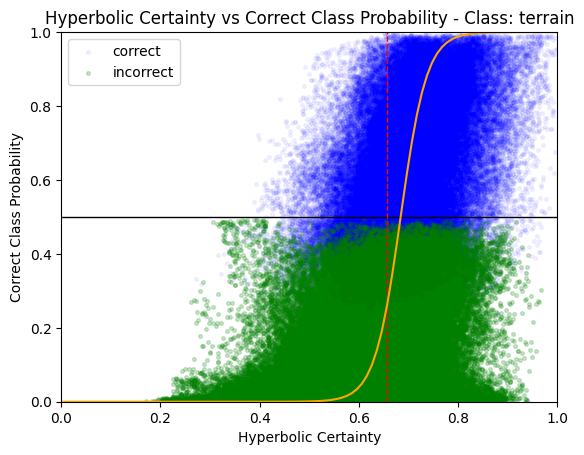

In [30]:
plot_corr_prob_cert(9, bias_factor=13, var_factor=19)

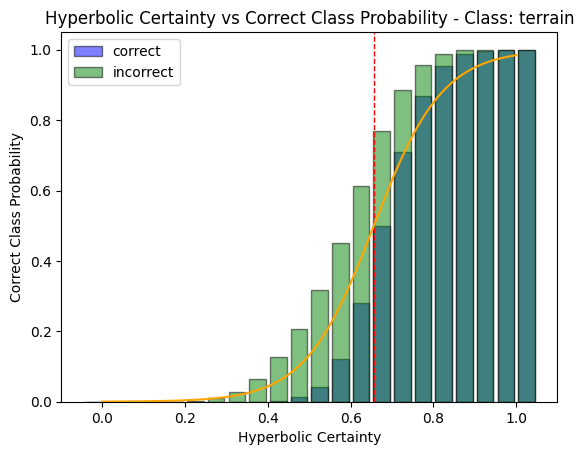

In [34]:
plot_density_cert(9, cumulative=True, density=True, mask='label')

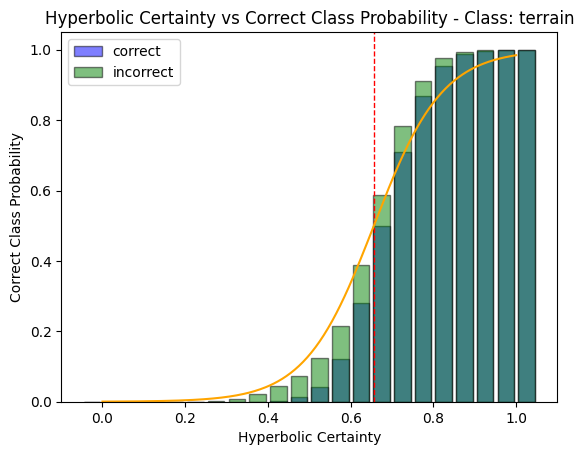

In [35]:
plot_density_cert(9, cumulative=True, density=True, mask='pred')

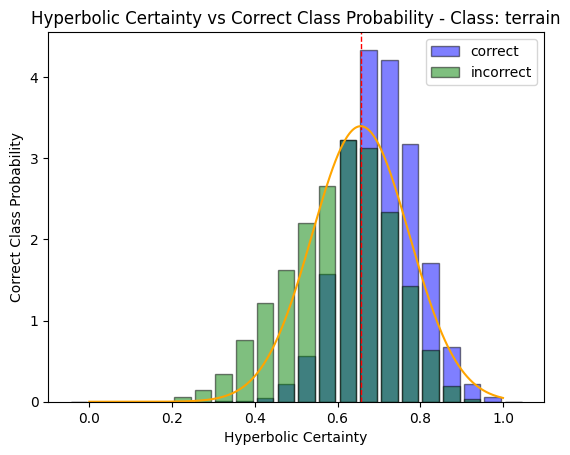

In [36]:
plot_density_cert(9, 'label')

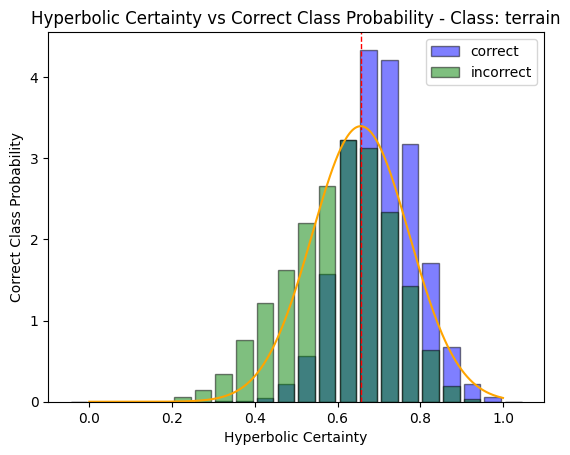

In [33]:
plot_density_cert(9, 'label')

In [42]:
class_id = 9

certainty_flatten = 1 - hyp_unc_tensor.reshape(-1)

label_flatten = label_tensor.reshape(-1)
pred_flatten = pred_tensor.reshape(-1)
correct_clas_prob = output_tensor[:, class_id, :, :].reshape(-1)

sel_class_mask = label_flatten==class_id

correct_pred = pred_flatten == label_flatten
incorrect_pred = pred_flatten != label_flatten

corr_sel_class_mask = sel_class_mask & correct_pred
incorr_sel_class_mask = sel_class_mask & incorrect_pred

certainty_flatten_filtered = certainty_flatten[corr_sel_class_mask]
correct_clas_prob_filtered = correct_clas_prob[corr_sel_class_mask]

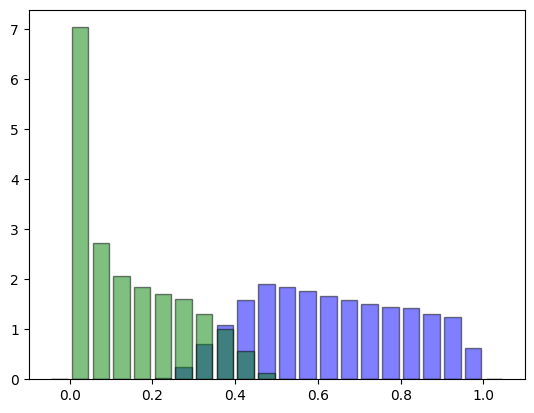

In [46]:
_ = plt.hist(correct_clas_prob[corr_sel_class_mask], bins=np.arange(-0.05,1.1,0.05), edgecolor='black', rwidth=0.8, color='blue', density=True, cumulative=False, alpha=0.5, label='correct')
_ = plt.hist(correct_clas_prob[incorr_sel_class_mask], bins=np.arange(-0.05,1.1,0.05), edgecolor='black', rwidth=0.8, color='green', density=True, cumulative=False, alpha=0.5, label='incorrect')

In [57]:
class_id = 13
idx = 0

certainty_flatten = 1 - hyp_unc_tensor[idx] #.reshape(-1)

label_flatten = label_tensor[idx] #.reshape(-1)
pred_flatten = pred_tensor[idx] #.reshape(-1)
correct_class_prob = output_tensor[idx, class_id, :, :] #.reshape(-1)

sel_class_mask = (label_flatten==class_id)*1

certainty_flatten.shape, label_flatten.shape, pred_flatten.shape, correct_class_prob.shape, sel_class_mask.shape, sel_class_mask.sum()

(torch.Size([160, 320]),
 torch.Size([160, 320]),
 torch.Size([160, 320]),
 torch.Size([160, 320]),
 torch.Size([160, 320]),
 tensor(5607))

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

Text(0.5, 1.0, 'Correct class Probability of the selected class')

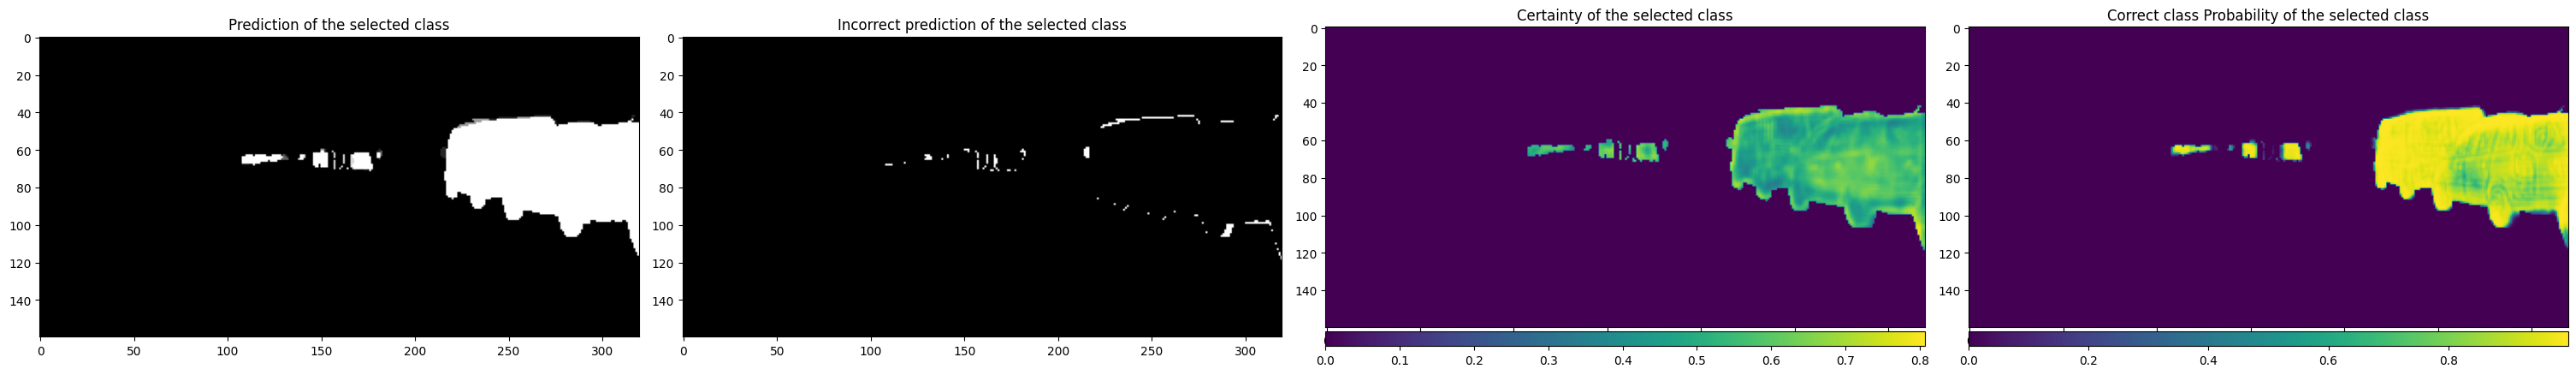

In [71]:
fig, axes = plt.subplots(1, 4, figsize= (30, 15), constrained_layout = True) # constrained_layout = True



axes[0].imshow(pred_flatten * sel_class_mask, cmap='gray')
axes[0].set_title('Prediction of the selected class')

axes[1].imshow(pred_flatten*sel_class_mask != label_flatten*sel_class_mask, cmap='gray')
axes[1].set_title('Incorrect prediction of the selected class')

im0 = axes[2].imshow(certainty_flatten * sel_class_mask, cmap='viridis')
divider = make_axes_locatable(axes[2])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
fig.colorbar(im0, cax=cax, orientation='horizontal')
axes[2].set_title('Certainty of the selected class')

im3 = axes[3].imshow(correct_class_prob * sel_class_mask, cmap='viridis')
divider = make_axes_locatable(axes[3])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='horizontal')
axes[3].set_title('Correct class Probability of the selected class')

In [ ]:
sel_class_mask = label_flatten==class_id

correct_pred = pred_flatten == label_flatten
incorrect_pred = pred_flatten != label_flatten

corr_sel_class_mask = sel_class_mask & correct_pred
incorr_sel_class_mask = sel_class_mask & incorrect_pred

certainty_flatten_filtered = certainty_flatten[corr_sel_class_mask]
correct_class_prob_filtered = correct_class_prob[corr_sel_class_mask]

In [ ]:
plot_corr_prob_cert(18, bias_factor=57, var_factor=70)
plot_corr_prob_cert(16, bias_factor=13, var_factor=17)
plot_corr_prob_cert(14, bias_factor=19, var_factor=26)

In [ ]:
unc_mean_class = class_stat[extract_classname(9)][0]
unc_var_class = class_stat[extract_classname(9)][1]
print(unc_mean_class, 1/np.sqrt(2*unc_var_class))

In [ ]:
20/np.sqrt(2*unc_var_class)

In [ ]:
149/13

In [ ]:
plot_corr_prob_cert(13, bias_factor=25, var_factor=40)

In [ ]:
plot_corr_prob_cert(13, bias_factor=25, var_factor=40)

In [ ]:
plot_corr_prob_cert(3, bias_factor=10.5, var_factor=16)

In [ ]:
class_id = 18
print("Class:", extract_classname(class_id))

certainty_flatten = 1 - hyp_unc_tensor.reshape(-1)

label_flatten = label_tensor.reshape(-1)
correct_clas_prob = output_tensor[:, class_id, :, :].reshape(-1)

sel_class_mask = label_flatten==class_id

certainty_flatten_filtered = certainty_flatten[sel_class_mask]
correct_clas_prob_filtered = correct_clas_prob[sel_class_mask]

In [ ]:
plt.scatter(certainty_flatten_filtered, correct_clas_prob_filtered, alpha=.6, s=7)
plt.axvline(1 - class_stat[extract_classname(class_id)][0], color='red', linestyle='dashed', linewidth=1)

plt.xlabel('Hyperbolic Certainty')
plt.ylabel('Correct Class Probability')
plt.title('Hyperbolic Certainty vs Correct Class Probability - Class: '+extract_classname(class_id))

In [ ]:
plt.scatter(certainty_flatten_filtered, correct_clas_prob_filtered, alpha=.6, s=7)
plt.axvline(1 - class_stat[extract_classname(class_id)][0], color='red', linestyle='dashed', linewidth=1)

plt.xlabel('Hyperbolic Certainty')
plt.ylabel('Correct Class Probability')
plt.title('Hyperbolic Certainty vs Correct Class Probability - Class: '+extract_classname(class_id))

In [ ]:
plt.scatter(certainty_flatten_filtered, correct_clas_prob_filtered, alpha=.6, s=7)
plt.axvline(1 - class_stat[extract_classname(class_id)][0], color='red', linestyle='dashed', linewidth=1)

plt.xlabel('Hyperbolic Certainty')
plt.ylabel('Correct Class Probability')
plt.title('Hyperbolic Certainty vs Correct Class Probability - Class: '+extract_classname(class_id))

In [ ]:
plt.scatter(certainty_flatten_filtered, correct_clas_prob_filtered, alpha=.6, s=7)
plt.axvline(1 - class_stat[extract_classname(class_id)][0], color='red', linestyle='dashed', linewidth=1)

plt.xlabel('Hyperbolic Certainty')
plt.ylabel('Correct Class Probability')
plt.title('Hyperbolic Certainty vs Correct Class Probability - Class: '+extract_classname(class_id))

In [ ]:
plt.scatter(certainty_flatten_filtered, correct_clas_prob_filtered, alpha=.6, s=7)
unc_mean_class = 1 - class_stat[extract_classname(class_id)][0]
plt.axvline(unc_mean_class, color='red', linestyle='dashed', linewidth=1)
plt.plot(x, f(x, -6*unc_mean_class, 7), color='orange')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('Hyperbolic Certainty')
plt.ylabel('Correct Class Probability')
plt.title('Hyperbolic Certainty vs Correct Class Probability - Class: '+extract_classname(class_id))

In [ ]:
plt.scatter(certainty_flatten_filtered, correct_clas_prob_filtered, alpha=.6, s=7)
unc_mean_class = 1 - class_stat[extract_classname(class_id)][0]
plt.axvline(unc_mean_class, color='red', linestyle='dashed', linewidth=1)
plt.plot(x, f(x, -10*unc_mean_class, 12), color='green')

plt.xlabel('Hyperbolic Certainty')
plt.ylabel('Correct Class Probability')
plt.title('Hyperbolic Certainty vs Correct Class Probability - Class: '+extract_classname(class_id))

# Uncertainty Evolution

In [85]:
floating_region_score = FloatingRegionScore(in_channels=19, size=3, purity_type='ripu')

size = (1024, 2048)

hyp_unc_tensor = torch.empty(0, *size)

for idx in tqdm(range(output_tensor.shape[0])):
    output_sel = output_tensor[idx].unsqueeze(0)
    embed_sel = embed_tensor[idx].unsqueeze(0)
    # print(output_sel.shape, embed_sel.shape)
    output_sel_large = F.interpolate(output_sel, size=size, mode='bilinear', align_corners=True)
    embed_sel_large = F.interpolate(embed_sel, size=size, mode='bilinear', align_corners=True)
    # print(output_sel_large.shape, embed_sel_large.shape)
    _, _, hyp_uncert = floating_region_score(output_sel_large, decoder_out=embed_sel_large, normalize=True, unc_type='hyperbolic', pur_type='ripu')
    hyp_unc_tensor = torch.cat((hyp_unc_tensor, hyp_uncert.unsqueeze(0)), dim=0)

100%|██████████| 130/130 [06:31<00:00,  3.01s/it]


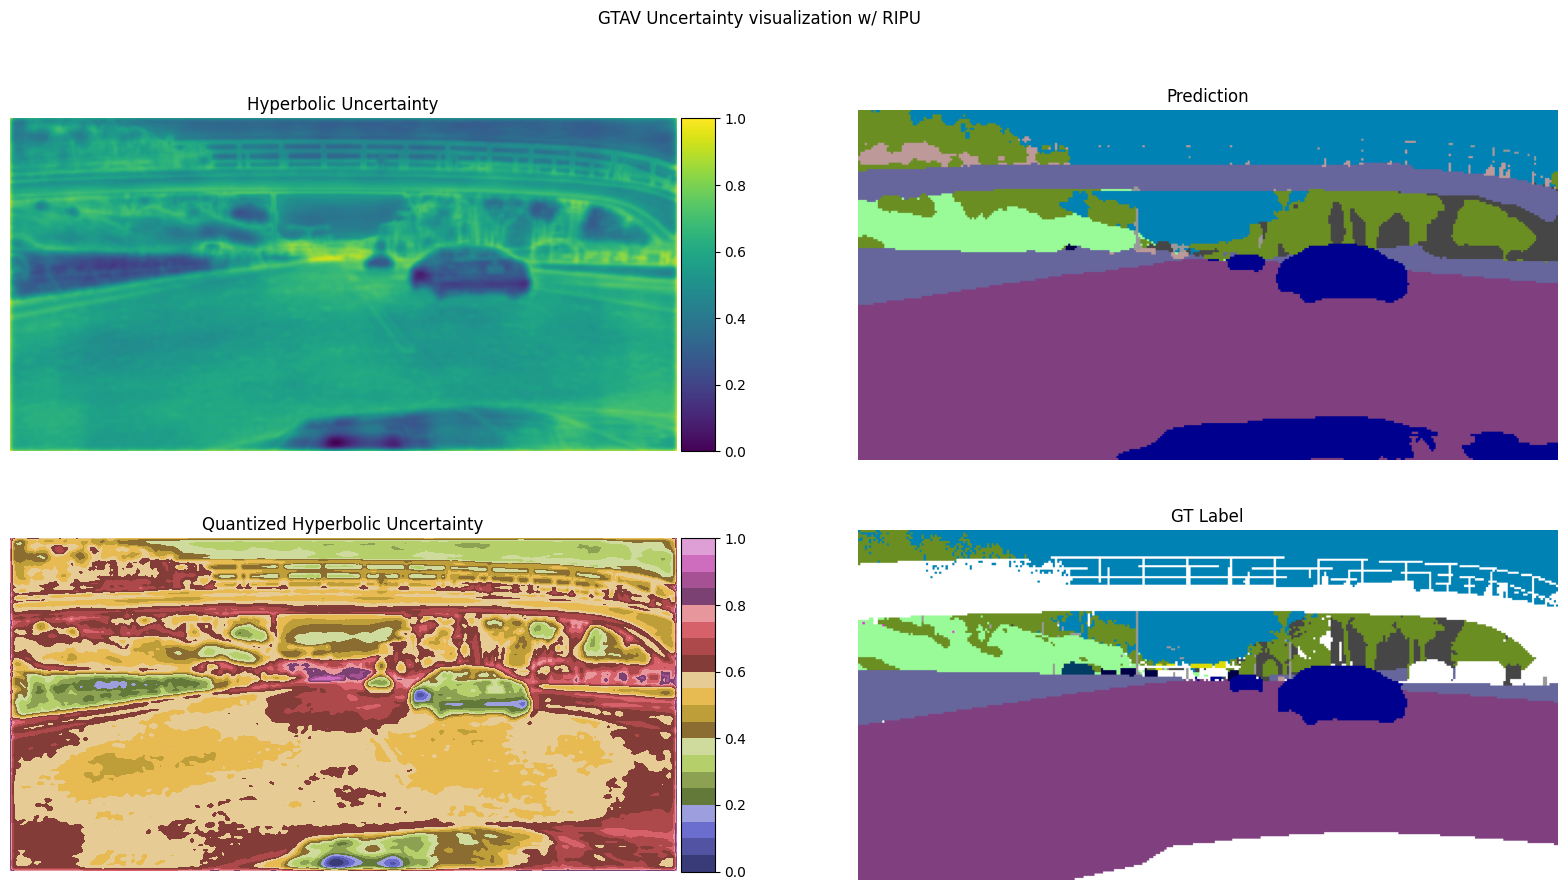

In [95]:
idx = 1
# size = (160, 320)

fig, axes = plt.subplots(2,2, figsize=(20, 10)) #, constrained_layout=True)

# hyp_unc_large = F.interpolate(hyp_unc_tensor[idx].unsqueeze(0).unsqueeze(0), size=size, mode='bilinear', align_corners=True).squeeze(0).squeeze(0)

# im0 = axes[0,0].imshow(hyp_unc_large.cpu(), cmap='viridis')
im0 = axes[0,0].imshow(hyp_unc_tensor[idx].cpu(), cmap='viridis')
axes[0,0].set_axis_off()
axes[0,0].set_title('Hyperbolic Uncertainty')
divider = make_axes_locatable(axes[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0, cax=cax, orientation='vertical')

pred_sel_large = F.interpolate(pred_tensor[idx].unsqueeze(0).unsqueeze(0), size=size, mode='nearest').squeeze(0).squeeze(0)
axes[0,1].imshow(get_color_pallete(pred_sel_large.cpu().numpy()))
axes[0,1].set_axis_off()
axes[0,1].set_title('Prediction')

# im0 = axes[1,0].imshow(hyp_unc_large.cpu(), cmap='tab20b')
im0 = axes[1,0].imshow(hyp_unc_tensor[idx].cpu(), cmap='tab20b')
axes[1,0].set_axis_off()
axes[1,0].set_title('Quantized Hyperbolic Uncertainty')
divider = make_axes_locatable(axes[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0, cax=cax, orientation='vertical')

label_sel_large = F.interpolate(label_tensor[idx].unsqueeze(0).unsqueeze(0), size=size, mode='nearest').squeeze(0).squeeze(0)
axes[1,1].imshow(get_color_pallete(label_sel_large.cpu().numpy()))
axes[1,1].set_axis_off()
axes[1,1].set_title('GT Label')

plt.suptitle('GTAV Uncertainty visualization w/ Euc RIPU')
plt.savefig('visualizzazioni/uncertainty/uncertainty_gtav_RIPU_pretrain.pdf', format="pdf", dpi=300, bbox_inches='tight')